In [1]:
!pip install metpy
!pip install rioxarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.9/409.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 26.1 MB/s eta 0:00:00


In [2]:
import numpy as np
from numpy import *
import xarray as xr
import metpy
import pandas as pd
import geopandas as gpd
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path_nc = '/content/drive/MyDrive/Thesis/RAW/GRACE_GSB.nc'
G_dataset = xr.open_dataset(file_path_nc)
months_missing = G_dataset.attrs.get('months_missing', 'Attribute not found')
dates = months_missing.replace(",", ";").split(";")
missing_dates = [(int(date.split("-")[0]), int(date.split("-")[1])) for date in dates]
missing_dates = [pd.Timestamp(year=year, month=month, day=1) for year, month in missing_dates]

In [6]:
cluster = "AQ"
nepal_shp = gpd.read_file('/content/drive/MyDrive/Thesis/SHP/TrunkKoshi.shp')
nepal_shp = nepal_shp.set_crs('epsg:4326')

In [ ]:
file_path_nc = '/content/drive/MyDrive/Thesis/RAW/GRACE_Aquifer.nc'
G_dataset = xr.open_dataset(file_path_nc)
months_missing = G_dataset.attrs.get('months_missing', 'Attribute not found')
dates = months_missing.replace(",", ";").split(";")
missing_dates = [(int(date.split("-")[0]), int(date.split("-")[1])) for date in dates]

# FLDAS

In [ ]:
import rioxarray
FLDAS_path = '/content/drive/MyDrive/Thesis/REGRID/FLDAS 0.1.nc'
output_folder = f'/content/drive/MyDrive/Thesis/RFM/Predictor/'
FLDAS = xr.open_dataset(FLDAS_path)
FLDAS = FLDAS.drop_vars('time_bnds', errors='ignore')
FLDAS = FLDAS.rio.write_crs('epsg:4326')
FLDAS = FLDAS.rio.clip(nepal_shp.geometry,all_touched=True)

FLDAS = FLDAS.rename({'X':'x','Y':'y'})
FLDAS['time'] = pd.to_datetime(FLDAS.indexes['time'])  #if the time is not in standard format

time_index = pd.to_datetime(FLDAS['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for year, month in missing_dates:
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
FLDAS_N = FLDAS.sel(time=mask[mask].index)
FLDAS_N = FLDAS_N.sel(time=slice('2003-01-01','2023-12-31'))
#FLDAS_N = FLDAS_N.rio.write_crs('epsg:4326')
#FLDAS_N = FLDAS_N.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

FLDAS_N

ModuleNotFoundError: No module named 'rioxarray'

In [7]:
#without masking
import rioxarray
FLDAS_path = '/content/drive/MyDrive/Thesis/REGRID/FLDAS 0.1.nc'
output_folder = f'/content/drive/MyDrive/Thesis/RFM/Predictor/'
FLDAS = xr.open_dataset(FLDAS_path)
FLDAS = FLDAS.drop_vars('time_bnds', errors='ignore')
FLDAS = FLDAS.rio.write_crs('epsg:4326')
FLDAS = FLDAS.rio.clip(nepal_shp.geometry,drop=True)

FLDAS = FLDAS.rename({'X':'x','Y':'y'})
FLDAS['time'] = pd.to_datetime(FLDAS.indexes['time'])  #if the time is not in standard format

time_index = pd.to_datetime(FLDAS['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)


# Apply the mask to filter the dataset
#FLDAS_N = FLDAS.sel(time=mask[mask].index)
FLDAS_N = FLDAS_N.sel(time=slice('2003-01-01','2020-12-31'))
#FLDAS_N = FLDAS_N.rio.write_crs('epsg:4326')
#FLDAS_N = FLDAS_N.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

print(FLDAS_N)
vars = [variable for variable in FLDAS_N.variables]
print(vars)
vars[8:12]
dynamic_vars = {}
for i in range(8, 12):
    dynamic_vars["iget" + vars[i]] = FLDAS_N[vars[i]]
    print(vars[i])

ValueError: cannot rename 'X' because it is not a variable or dimension in this dataset

## For Soil Moisture

In [ ]:
# Save the regridded data to a NetCDF file
vars = [variable for variable in FLDAS_N.variables]
print(vars)
vars[8:12]
dynamic_vars = {}
for i in range(8, 12):
    dynamic_vars["iget" + vars[i]] = FLDAS_N[vars[i]]
average_data_array = None

# Loop through each DataArray in the dictionary and compute the mean
for key, da in dynamic_vars.items():
    if average_data_array is None:
        average_data_array = da
    else:
        average_data_array += da
average_data_array /= len(dynamic_vars)
average_data_array.name = "SM"
average_data_array
SM_df = average_data_array.to_dataframe().reset_index()
SM_df = SM_df.sort_values(by=['time', 'x'])

#SM_df_drop = SM_df.drop(columns=['time','lat','lon'])
path = f'/content/drive/MyDrive/Thesis/RFM/Predictor/SM.csv'
os.makedirs(os.path.dirname(path), exist_ok=True)
SM_df.to_csv(path,index = False)
SM_df

['time', 'x', 'y', 'spatial_ref', 'Evap_tavg', 'Qs_tavg', 'RadT_tavg', 'SWE_inst', 'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', 'SoilMoi100_200cm_tavg']


time      y      x  spatial_ref  SM
0       2003-01-01  24.45  77.45            0 NaN
110     2003-01-01  24.55  77.45            0 NaN
220     2003-01-01  24.65  77.45            0 NaN
330     2003-01-01  24.75  77.45            0 NaN
440     2003-01-01  24.85  77.45            0 NaN
...            ...    ...    ...          ...  ..
1116279 2020-12-01  28.65  88.35            0 NaN
1116389 2020-12-01  28.75  88.35            0 NaN
1116499 2020-12-01  28.85  88.35            0 NaN
1116609 2020-12-01  28.95  88.35            0 NaN
1116719 2020-12-01  29.05  88.35            0 NaN

[1116720 rows x 5 columns]

In [ ]:
# Export each layer of SM
import xarray as xr

# List of variables in the dataset and filter the variables you need
vars = [variable for variable in FLDAS_N.variables]
print(vars)

# Dictionary to store individual data arrays for each selected variable
dynamic_vars = {}
for i in range(8, 12):
    dynamic_vars["iget" + vars[i]] = FLDAS_N[vars[i]]

# Loop through each DataArray and export as a separate CSV file
for key, da in dynamic_vars.items():
    # Convert to DataFrame and sort by 'time' and 'x' for consistency
    df = da.to_dataframe().reset_index()
    df = df.sort_values(by=['time', 'x'])

    # Define the output path and save to CSV
    output_file = path = f'/content/drive/MyDrive/Thesis/RFM/Predictor/{key}.csv'
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    df.to_csv(output_file, index=False)
    print(f"Exported {key} to {output_file}")


['time', 'x', 'y', 'spatial_ref', 'Evap_tavg', 'Qs_tavg', 'SWE_inst', 'Tair_f_tavg', 'SoilMoi00_10cm_tavg', 'SoilMoi10_40cm_tavg', 'SoilMoi40_100cm_tavg', 'SoilMoi100_200cm_tavg']
Exported igetSoilMoi00_10cm_tavg to /content/drive/MyDrive/Thesis/RFM/Predictor/Cluster 1/igetSoilMoi00_10cm_tavg.csv
Exported igetSoilMoi10_40cm_tavg to /content/drive/MyDrive/Thesis/RFM/Predictor/Cluster 1/igetSoilMoi10_40cm_tavg.csv
Exported igetSoilMoi40_100cm_tavg to /content/drive/MyDrive/Thesis/RFM/Predictor/Cluster 1/igetSoilMoi40_100cm_tavg.csv
Exported igetSoilMoi100_200cm_tavg to /content/drive/MyDrive/Thesis/RFM/Predictor/Cluster 1/igetSoilMoi100_200cm_tavg.csv


In [ ]:
import pandas as pd

# List all variables in the dataset
available_vars = list(FLDAS_N.data_vars)
print("Available variables for export:")
for i, var in enumerate(available_vars):
    print(f"{i + 1}: {var}")

# Prompt the user to select a variable
var_index = int(input("Enter the number of the variable you want to export: ")) - 1
if var_index < 0 or var_index >= len(available_vars):
    raise ValueError("Invalid selection. Please enter a number corresponding to one of the variables listed.")

# Retrieve the selected variable name
selected_var = available_vars[var_index]
print(f"Exporting variable: {selected_var}")

# Convert the selected variable to a DataFrame for export
df = FLDAS_N[selected_var].to_dataframe().reset_index()
df = df.sort_values(by=['time', 'x'])


# Specify the file path for the CSV export
csv_path = f'/content/drive/MyDrive/Thesis/RFM/Predictor/{selected_var}.csv'
df.to_csv(csv_path, index=False)

print(f"Variable '{selected_var}' has been exported to {csv_path}")


Available variables for export:
1: Evap_tavg
2: Qs_tavg
3: RadT_tavg
4: SWE_inst
5: SoilMoi00_10cm_tavg
6: SoilMoi10_40cm_tavg
7: SoilMoi40_100cm_tavg
8: SoilMoi100_200cm_tavg
Enter the number of the variable you want to export: f


ValueError: invalid literal for int() with base 10: 'f'

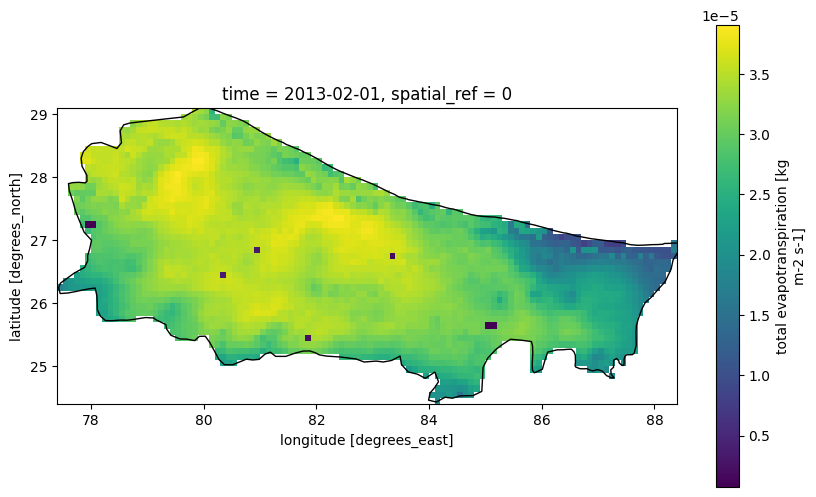

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# Transpose the dataset to switch lat (y) and lon (x)
FLDAS_N_transposed = FLDAS_N[list(FLDAS_N.data_vars)[0]].isel(time=121).transpose('y', 'x')
FLDAS_N_transposed.plot(ax=ax)
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

# Plot the shapefile
#nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()


# Precipitation

In [ ]:
!pip install cftime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.5 MB/s eta 0:00:00


In [ ]:
pr_nc = "/content/drive/MyDrive/Thesis/REGRID/IMERG 0.1.nc"
pr_dataset = xr.open_dataset(pr_nc)
pr_dataset = pr_dataset.rio.write_crs('epsg:4326')
pr_dataset = pr_dataset.rio.clip(nepal_shp.geometry,drop=True)
pr_dataset = pr_dataset.rename({'lon':'x','lat':'y'})
pr_dataset = pr_dataset.transpose('time','x', 'y')
filtered_dataset = pr_dataset.sel(time=slice('2003-01-01','2020-12-31'))

pr_df = filtered_dataset.to_dataframe().reset_index()
pr_df = pr_df.drop(columns='spatial_ref')
pr_df = pr_df.sort_values(by=['time','x'])
pr_df

time          x          y  precipitation
0       2003-01-01  77.449997  24.449999            NaN
1       2003-01-01  77.449997  24.549999            NaN
2       2003-01-01  77.449997  24.650000            NaN
3       2003-01-01  77.449997  24.750000            NaN
4       2003-01-01  77.449997  24.850000            NaN
...            ...        ...        ...            ...
1116715 2020-12-01  88.349998  28.650000            NaN
1116716 2020-12-01  88.349998  28.750000            NaN
1116717 2020-12-01  88.349998  28.849998            NaN
1116718 2020-12-01  88.349998  28.949999            NaN
1116719 2020-12-01  88.349998  29.049999            NaN

[1116720 rows x 4 columns]

In [ ]:
pr_df.to_csv(f'/content/drive/MyDrive/Thesis/RFM/Predictor/precipitation.csv', index=False)

# NDVI

In [ ]:
file_path_nc = '/content/drive/MyDrive/Thesis/GRACE_Clipped_converted.nc'
G_dataset = xr.open_dataset(file_path_nc)
months_missing = G_dataset.attrs.get('months_missing', 'Attribute not found')
dates = months_missing.replace(",", ";").split(";")
missing_dates = [(int(date.split("-")[0]), int(date.split("-")[1])) for date in dates]
missing_dates = [pd.Timestamp(year=year, month=month, day=1) for year, month in missing_dates]

In [ ]:
file_path_nc = "/content/drive/MyDrive/Thesis/REGRID/NDVI_2003_2023.nc"
dataset = xr.open_dataset(file_path_nc)
regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)
NDVI = dataset['NDVI'].interp(lat = regrid_lat,lon=regrid_lon,method='slinear')
NDVI = NDVI.rio.write_crs('epsg:4326')
NDVI = NDVI.rename({'lon':'x','lat':'y'})
NDVI = NDVI.rio.clip(nepal_shp.geometry,all_touched=True)
NDVI = NDVI.transpose('time','x', 'y')
NDVI
time_index = pd.to_datetime(NDVI['time'].values)
mask = pd.Series(True, index=time_index)  # Start with all True (include all data)

for timestamp in missing_dates:
    year = timestamp.year
    month = timestamp.month
    # Exclude dates that match the missing year and month
    mask &= ~((time_index.year == year) & (time_index.month == month))

    mask &= ~((time_index.year == year) & (time_index.month == month))

# Apply the mask to filter the dataset
filtered_dataset = NDVI.sel(time=mask[mask].index)
filtered_dataset = filtered_dataset.sel(time=slice('2003-02-01','2016-12-31'))

NDVI_df = filtered_dataset.to_dataframe().reset_index()
NDVI_df
df.to_csv(f'/content/drive/MyDrive/Thesis/RFM/Predictor/{cluster}/NDVI.csv', index=False)


In [ ]:
#!pip install cftime
import cftime
ndvi_path = '/content/drive/MyDrive/Thesis/REGRID/NDVI 10.nc'
NDVI = xr.open_dataset(ndvi_path, decode_times=False)
time_var = NDVI.variables['time']  # Replace 'time' with the actual variable name if different
units = time_var.attrs['units']
calendar = time_var.attrs.get('calendar', 'standard')  # Get calendar, default to 'standard'

# Create a cftime.num2date function for conversion
num2date = cftime.num2date if calendar != 'standard' else cftime.num2date

# Decode the time values
dates = num2date(time_var.values, units=units, calendar=calendar)

# Assign the decoded dates back to the time variable
NDVI['time'] = dates

# Continue with your analysis using the updated NDVI dataset
NDVI = NDVI.rio.write_crs('epsg:4326')
NDVI = NDVI.rio.clip(nepal_shp.geometry,drop = True)
#NDVI = NDVI.isel(lat=slice(1, None))
print(NDVI)



<xarray.Dataset> Size: 10MB
Dimensions:             (time: 252, lat: 47, lon: 110)
Coordinates:
  * time                (time) object 2kB 2003-01-01 00:00:00 ... 2023-12-01 ...
  * lat                 (lat) float64 376B 24.47 24.57 24.67 ... 28.97 29.07
  * lon                 (lon) float64 880B 77.48 77.58 77.68 ... 88.28 88.38
    spatial_ref         int64 8B 0
    crs                 int64 8B 0
Data variables:
    _1_km_monthly_NDVI  (time, lat, lon) float64 10MB nan nan nan ... nan nan
Attributes:
    Conventions:         CF-1.6
    history:             Fri Jan 31 19:47:03 2025: GDAL CreateCopy( D:/Master...
    institution:         Land Processes Distributed Active Archive Center (LP...
    references:          See README.md
    source:              AppEEARS v3.71
    title:               MOD13A3.061 for aid0001
    GDAL_AREA_OR_POINT:  Area
    GDAL:                GDAL 3.9.1, released 2024/06/22


In [ ]:
print(NDVI)

<xarray.Dataset> Size: 10MB
Dimensions:             (time: 252, lat: 46, lon: 110)
Coordinates:
  * time                (time) object 2kB 2003-01-01 00:00:00 ... 2023-12-01 ...
  * lat                 (lat) float64 368B 24.57 24.67 24.77 ... 28.97 29.07
  * lon                 (lon) float64 880B 77.48 77.58 77.68 ... 88.28 88.38
    spatial_ref         int64 8B 0
    crs                 int64 8B 0
Data variables:
    _1_km_monthly_NDVI  (time, lat, lon) float64 10MB nan nan nan ... nan nan
Attributes:
    Conventions:         CF-1.6
    history:             Fri Jan 31 19:47:03 2025: GDAL CreateCopy( D:/Master...
    institution:         Land Processes Distributed Active Archive Center (LP...
    references:          See README.md
    source:              AppEEARS v3.71
    title:               MOD13A3.061 for aid0001
    GDAL_AREA_OR_POINT:  Area
    GDAL:                GDAL 3.9.1, released 2024/06/22


In [ ]:
filtered_dataset = NDVI.sel(time=slice('2003-01-01','2020-12-31'))

ndvi_df = filtered_dataset.to_dataframe().reset_index()
ndvi_df = ndvi_df.drop(columns=['spatial_ref','crs'], errors='ignore')
ndvi_df = ndvi_df.sort_values(by=['time','lon'])
ndvi_df = ndvi_df.rename(columns={'_1_km_monthly_NDVI':'NDVI'})
ndvi_df

time     lat        lon  NDVI
0        2003-01-01 00:00:00  24.475  77.478931   NaN
110      2003-01-01 00:00:00  24.575  77.478931   NaN
220      2003-01-01 00:00:00  24.675  77.478931   NaN
330      2003-01-01 00:00:00  24.775  77.478931   NaN
440      2003-01-01 00:00:00  24.875  77.478931   NaN
...                      ...     ...        ...   ...
1116279  2020-12-01 00:00:00  28.675  88.378931   NaN
1116389  2020-12-01 00:00:00  28.775  88.378931   NaN
1116499  2020-12-01 00:00:00  28.875  88.378931   NaN
1116609  2020-12-01 00:00:00  28.975  88.378931   NaN
1116719  2020-12-01 00:00:00  29.075  88.378931   NaN

[1116720 rows x 4 columns]

In [ ]:
ndvi_df.to_csv(f'/content/drive/MyDrive/Thesis/RFM/Predictor/NDVI.csv', index=False)

# Elevation

In [ ]:
path = '/content/drive/MyDrive/Thesis/RFM/Predictor/DEM'

In [ ]:
import rioxarray
import numpy as np

# Load the DEM file
dem_file = '/content/drive/MyDrive/Thesis/REGRID/DEM 10 KM.tif'
dem = rioxarray.open_rasterio(dem_file)

# Clip the dataset using the Nepal shapefile geometry
dem = dem.rio.clip(nepal_shp.geometry, drop=True)

# Replace _FillValue with NaN
if '_FillValue' in dem.attrs:
    fill_value = dem.attrs['_FillValue']
    dem = dem.where(dem != fill_value, np.nan)

# Display the dataset
dem


<xarray.DataArray (band: 1, y: 47, x: 110)> Size: 41kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 880B 77.45 77.55 77.65 77.75 ... 88.15 88.25 88.35
  * y            (y) float64 376B 29.05 28.95 28.85 28.75 ... 24.65 24.55 24.45
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -32768

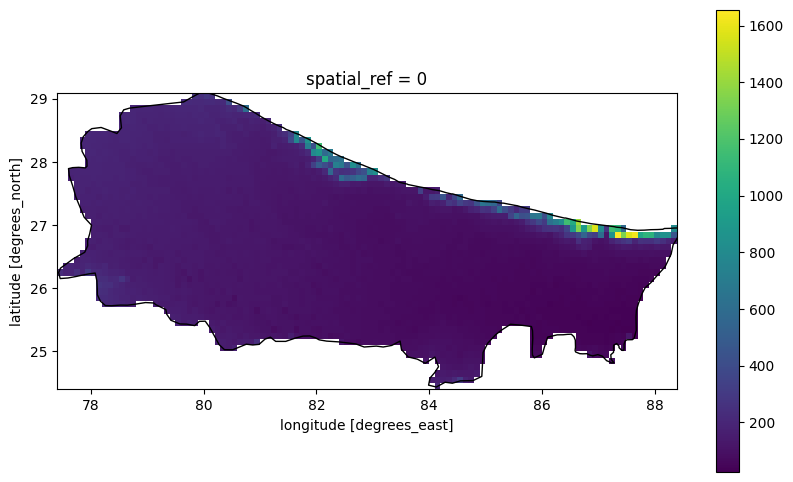

In [ ]:
import rioxarray
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

dem = dem.squeeze(dim="band", drop=True)
#dem = dem.rio.clip(nepal_shp.geometry,drop= True)
#dem = dem.where(dem != 0, np.nan)
# Transpose the dataset to switch lat (y) and lon (x)
dem_tr = dem.transpose('y', 'x')
dem_tr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [ ]:
dem.name = "elevation"
demdf = dem.to_dataframe().reset_index()
demdf = demdf.sort_values(by=['x','y'])
demdf
# Export to CSV
os.makedirs(path, exist_ok=True)
demdf.to_csv(f'{path}/elevation.csv', index=False)

# Slope

In [ ]:
import rioxarray
slope_file = "/content/drive/MyDrive/Thesis/REGRID/Slope.tif"
slope_ds = rioxarray.open_rasterio(slope_file)

# Set the current CRS and reproject to EPSG:4326
slope_ds = slope_ds.rio.write_crs("EPSG:32645")  # Original CRS
slope_ds = slope_ds.rio.reproject("EPSG:4326")
regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)
slope = slope_ds.interp(y = regrid_lat,x=regrid_lon,method='slinear')

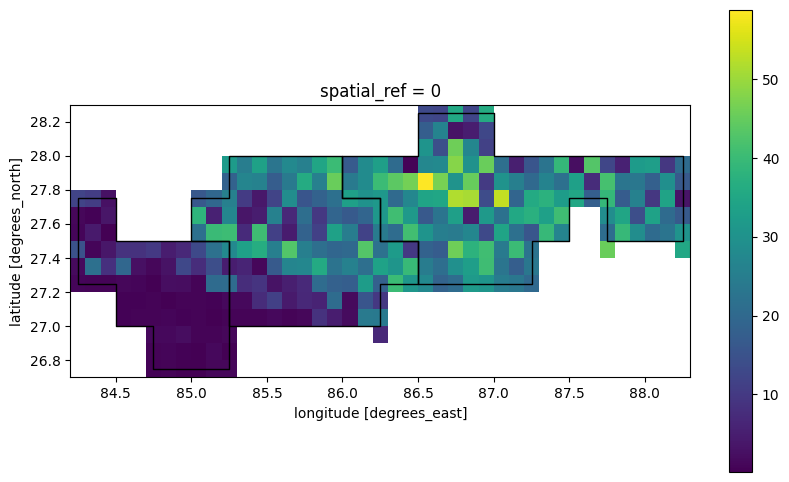

In [ ]:
import rioxarray
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

slope = slope.squeeze(dim="band", drop=True)
slope = slope.rio.clip(nepal_shp.geometry,all_touched= True)
fill_value = slope.attrs.get('_FillValue', None)
slope = slope.where(slope != fill_value, np.nan)
#tolerance = 0.01
#slope = slope.where(~((slope > -9999 - tolerance) & (slope < -9999 + tolerance)), np.nan)

#slope = slope.where(slope != 0, np.nan)
# Transpose the dataset to switch lat (y) and lon (x)
slope_tr = slope.transpose('y', 'x')
slope_tr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [ ]:
slope.name = "slope"
slopedf = slope.to_dataframe().reset_index()
slopedf = slopedf.sort_values(by=['x','y'])
slopedf
# Export to CSV
slopedf.to_csv(f'{path}/slope.csv', index=False)

# Aspect

In [ ]:
import rioxarray
aspect_file = "/content/drive/MyDrive/Thesis/REGRID/Aspect.tif"
aspect_ds = rioxarray.open_rasterio(aspect_file)

# Set the current CRS and reproject to EPSG:4326
aspect_ds = aspect_ds.rio.write_crs("EPSG:32645")  # Original CRS
aspect_ds = aspect_ds.rio.reproject("EPSG:4326")
fill_value = aspect_ds.attrs.get('_FillValue', None)
aspect_ds = aspect_ds.where(aspect_ds != fill_value, np.nan)
regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)
aspect = aspect_ds.interp(y = regrid_lat,x=regrid_lon,method='slinear')

In [ ]:
aspect_ds

<xarray.DataArray (band: 1, y: 19117, x: 26670)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * x            (x) float64 213kB 73.32 73.32 73.32 73.32 ... 95.6 95.6 95.6
  * y            (y) float64 153kB 34.68 34.68 34.67 34.67 ... 18.71 18.71 18.7
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     -9999.0

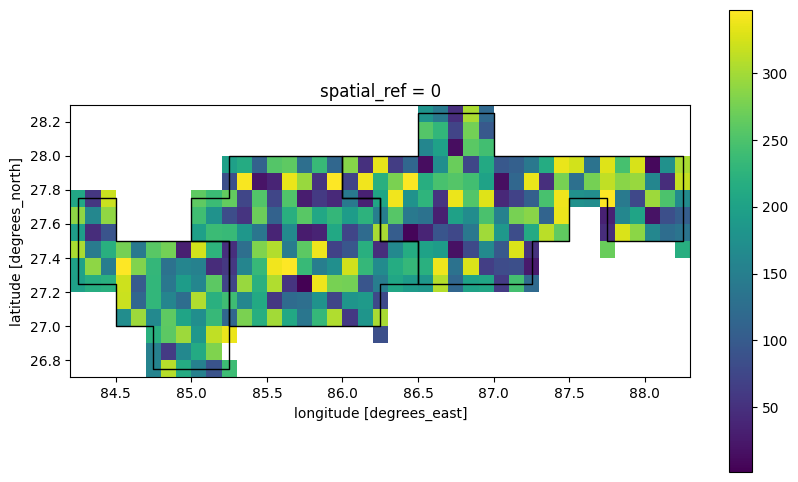

In [ ]:
import rioxarray
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

#aspect = aspect.squeeze(dim="band", drop=True)
aspect = aspect.rio.clip(nepal_shp.geometry,all_touched= True)
fill_value = aspect.attrs.get('_FillValue', None)
aspect = aspect.where(aspect != fill_value, np.nan)
#tolerance = 0.01
#aspect = aspect.where(~((aspect > -9999 - tolerance) & (aspect < -9999 + tolerance)), np.nan)

#aspect = aspect.where(aspect != 0, np.nan)
# Transpose the dataset to switch lat (y) and lon (x)
aspect_tr = aspect.transpose('y', 'x')
aspect_tr.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

In [ ]:
aspect.name = "aspect"
aspectdf = aspect.to_dataframe().reset_index()
aspectdf = aspectdf.sort_values(by=['x','y'])
aspectdf
# Export to CSV
aspectdf.to_csv(f'{path}/aspect.csv', index=False)

In [ ]:
import pandas as pd
import os

# Folder containing the CSV files
input_folder = f'/content/drive/MyDrive/Thesis/RFM/Predictor/DEM'
output_folder = f'/content/drive/MyDrive/Thesis/RFM/Predictor/'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Step 2: Create a date range from 2003-02-01 to 2016-12-31 (monthly frequency)
date_range = pd.date_range(start='2003-01-01', end='2020-12-31', freq='MS')

# Define missing dates and convert to datetime
#missing_dates = pd.to_datetime(missing_dates, format='%Y-%m')
#filtered_date_range = date_range[~date_range.isin(missing_dates)]

# Loop through each CSV file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith('.csv'):
        # Step 1: Read each original CSV file
        file_path = os.path.join(input_folder, file_name)
        original_data = pd.read_csv(file_path)

        # Step 5: Repeat the original data for each valid date (excluding the missing ones)
        #extended_data = pd.concat([original_data] * len(filtered_date_range), ignore_index=True)
        extended_data = pd.concat([original_data] * len(date_range), ignore_index=True)
        #extended_data['time'] = filtered_date_range.repeat(len(original_data)).values

        # Step 6: Export the new data with the time dimension to a new CSV file
        output_file = os.path.join(output_folder, f'extended_{file_name}')
        extended_data.to_csv(output_file, index=False)

        print(f"Processed and saved {output_file}")

print("All files have been processed and saved.")

Processed and saved /content/drive/MyDrive/Thesis/RFM/Predictor/extended_elevation.csv
All files have been processed and saved.


# Check number of data

In [ ]:
import os
import pandas as pd

# Path to the folder containing the CSV files
folder_path = f'/content/drive/MyDrive/Thesis/RFM/Predictor/'

# Loop through each file in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):  # Only process CSV files
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Print the file name and the number of rows
        print(f'File: {filename}, Number of rows: {len(df)}')

File: SM.csv, Number of rows: 1116720
File: Evap_tavg.csv, Number of rows: 1116720
File: Qs_tavg.csv, Number of rows: 1116720
File: RadT_tavg.csv, Number of rows: 1116720
File: extended_elevation.csv, Number of rows: 1116720
File: precipitation.csv, Number of rows: 1116720
File: combined_csv.csv, Number of rows: 1116720
File: NDVI.csv, Number of rows: 1116720


In [ ]:
import os
import pandas as pd

# Specify the folder containing the CSV files
folder_path = '/content/drive/MyDrive/Thesis/RFM/Predictor/'

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Loop through each CSV file and display its first few rows
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    try:
        df = pd.read_csv(file_path)  # Read the CSV file
        print(f"Preview of {file}:")
        print(df.head())  # Display first 5 rows
        print("\n" + "-"*50 + "\n")  # Separator for better readability
    except Exception as e:
        print(f"Could not read {file}: {e}")


Preview of SM.csv:
         time      y      x  spatial_ref  SM
0  2003-01-01  24.45  77.45            0 NaN
1  2003-01-01  24.55  77.45            0 NaN
2  2003-01-01  24.65  77.45            0 NaN
3  2003-01-01  24.75  77.45            0 NaN
4  2003-01-01  24.85  77.45            0 NaN

--------------------------------------------------

Preview of Evap_tavg.csv:
         time      y      x  spatial_ref  Evap_tavg
0  2003-01-01  24.45  77.45            0        NaN
1  2003-01-01  24.55  77.45            0        NaN
2  2003-01-01  24.65  77.45            0        NaN
3  2003-01-01  24.75  77.45            0        NaN
4  2003-01-01  24.85  77.45            0        NaN

--------------------------------------------------

Preview of Qs_tavg.csv:
         time      y      x  spatial_ref  Qs_tavg
0  2003-01-01  24.45  77.45            0      NaN
1  2003-01-01  24.55  77.45            0      NaN
2  2003-01-01  24.65  77.45            0      NaN
3  2003-01-01  24.75  77.45            0   

In [ ]:
import os
import pandas as pd

# Function to get the columns to copy from each CSV file
def select_columns(df, file_name):
    print(f"Available columns in {file_name}:")
    print(df.columns.tolist())

    # Ask the user for the column names they want to copy
    selected_columns = input("Enter the columns to copy (separated by commas): ").split(",")
    selected_columns = [col.strip() for col in selected_columns]  # Remove leading/trailing spaces
    return df[selected_columns]

# Folder where the CSV files are located
folder_path = f'/content/drive/MyDrive/Thesis/RFM/Predictor/'

# Create an empty DataFrame to store the combined data
combined_df = pd.DataFrame()

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)

        # Read the CSV file
        df = pd.read_csv(file_path)

        # Ask the user which columns to copy
        selected_data = select_columns(df, file_name)

        # Add the selected columns to the combined DataFrame
        combined_df = pd.concat([combined_df, selected_data], axis=1)

# Save the combined DataFrame to a new CSV file
combined_df.to_csv(f"/content/drive/MyDrive/Thesis/RFM/Predictor/combined_csv.csv", index=False)
print("Combined CSV file created: combined_csv_file.csv")

Available columns in SM.csv:
['time', 'y', 'x', 'spatial_ref', 'SM']
Enter the columns to copy (separated by commas): time, y, x, SM
Available columns in Evap_tavg.csv:
['time', 'y', 'x', 'spatial_ref', 'Evap_tavg']
Enter the columns to copy (separated by commas): Evap_tavg
Available columns in Qs_tavg.csv:
['time', 'y', 'x', 'spatial_ref', 'Qs_tavg']
Enter the columns to copy (separated by commas): Qs_tavg
Available columns in RadT_tavg.csv:
['time', 'y', 'x', 'spatial_ref', 'RadT_tavg']
Enter the columns to copy (separated by commas): RadT_tavg
Available columns in extended_elevation.csv:
['y', 'x', 'spatial_ref', 'elevation']
Enter the columns to copy (separated by commas): elevation
Available columns in precipitation.csv:
['time', 'x', 'y', 'precipitation']
Enter the columns to copy (separated by commas): precipitation
Available columns in NDVI.csv:
['time', 'lat', 'lon', 'NDVI']
Enter the columns to copy (separated by commas): NDVI
Combined CSV file created: combined_csv_file.csv


# Downscaled

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Hp\AppData\Local\Temp\ipykernel_18688\158457337.py:1: SyntaxWarning: invalid escape sequence '\M'
  file_path_nc = "D:\Masters\Thesis_New\Terai\Predictor\GRACE_0.1_Cluster 5.nc"


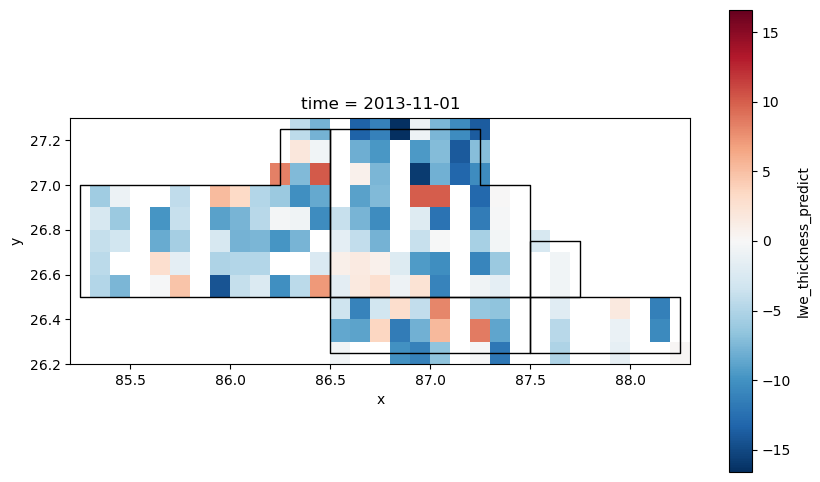

In [ ]:
file_path_nc = "D:\Masters\Thesis_New\Terai\Predictor\GRACE_0.1_Cluster 5.nc"
G_dataset = xr.open_dataset(file_path_nc)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# Transpose the dataset to switch lat (y) and lon (x)
GR = G_dataset.lwe_thickness_predict.isel(time=121).transpose('y', 'x')
GR.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

# Handling Residuals

In [ ]:
import numpy as np
grace_pr = xr.open_dataset("D:\Masters\Thesis_New\Terai\Predictor\GRACE_0.1_Cluster 5.nc")
regrid_lat = np.arange(21.125,32.125,0.25)
regrid_lon = np.arange(76.125,92.125,0.25)
grace_pr_regrid = grace_pr.interp(x=regrid_lon,y = regrid_lat,method='slinear')
grace_pr_regrid = grace_pr_regrid.rio.write_crs('epsg:4326')
grace_pr_regrid = grace_pr_regrid.rio.clip(nepal_shp.geometry,all_touched=True)
grace_pr_df = grace_pr_regrid.to_dataframe().reset_index()
grace_pr_df = grace_pr_df.sort_values(by=['time', 'x'])
grace_pr_df

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Hp\AppData\Local\Temp\ipykernel_21460\3682020742.py:2: SyntaxWarning: invalid escape sequence '\M'
  grace_pr = xr.open_dataset("D:\Masters\Thesis_New\Terai\Predictor\GRACE_0.1_Cluster 5.nc")


time       x       y  spatial_ref  lwe_thickness_predict
0     2003-02-01  85.375  26.375            0                    NaN
1     2003-02-01  85.375  26.625            0                    NaN
2     2003-02-01  85.375  26.875            0              -16.59824
3     2003-02-01  85.375  27.125            0                    NaN
4     2003-02-01  85.625  26.375            0                    NaN
...          ...     ...     ...          ...                    ...
7195  2016-12-01  87.875  27.125            0                    NaN
7196  2016-12-01  88.125  26.375            0                    NaN
7197  2016-12-01  88.125  26.625            0                    NaN
7198  2016-12-01  88.125  26.875            0                    NaN
7199  2016-12-01  88.125  27.125            0                    NaN

[7200 rows x 5 columns]

In [ ]:
grace_pr

<xarray.Dataset>
Dimensions:                (time: 150, y: 11, x: 31)
Coordinates:
  * time                   (time) object '2003-02-01' ... '2016-12-01'
  * x                      (x) float64 85.25 85.35 85.45 ... 88.05 88.15 88.25
  * y                      (y) float64 26.25 26.35 26.45 ... 27.05 27.15 27.25
Data variables:
    lwe_thickness_predict  (time, y, x) float64 nan nan nan nan ... nan nan nan

In [ ]:
grace_ori = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_Clipped_converted.nc')
grace_ori = grace_ori.drop_vars('time_bounds')
grace_ori = grace_ori.rio.write_crs('epsg:4326')
grace_ori = grace_ori.rename({'lon':'x','lat':'y'})
grace_ori = grace_ori.rio.clip(nepal_shp.geometry,all_touched=True)
grace_ori_clip = grace_ori.sel(time=slice('2003-02-01','2016-12-31'))
grace_ori_clip = grace_ori_clip[['lwe_thickness']]
Gdf1 = grace_ori_clip.to_dataframe().reset_index()
Gdf1 = Gdf1.sort_values(by=['time', 'x'])
Gdf1

time       y       x  lwe_thickness  spatial_ref  WGS84
0    2003-02-15  26.375  85.375            NaN            0      0
12   2003-02-15  26.625  85.375       4.849241            0      0
24   2003-02-15  26.875  85.375       4.849241            0      0
36   2003-02-15  27.125  85.375            NaN            0      0
1    2003-02-15  26.375  85.625            NaN            0      0
...         ...     ...     ...            ...          ...    ...
7198 2016-12-24  27.125  87.875            NaN            0      0
7163 2016-12-24  26.375  88.125     -25.564869            0      0
7175 2016-12-24  26.625  88.125            NaN            0      0
7187 2016-12-24  26.875  88.125            NaN            0      0
7199 2016-12-24  27.125  88.125            NaN            0      0

[7200 rows x 6 columns]

In [ ]:
# Calculate the residuals
grace_pr_df['residuals'] = Gdf1['lwe_thickness'] - grace_pr_df['lwe_thickness_predict']



In [ ]:
grace_pr_df.to_csv('D:/Masters/Thesis_New/Terai/Predictor/residual.csv', index=False)

In [ ]:
import xarray as xr

# Select the desired columns for the dataset
res = grace_pr_df[['time', 'x', 'y', 'residuals']]

# Convert the DataFrame to an xarray Dataset
residual = res.set_index(['time', 'x', 'y']).to_xarray()



In [ ]:
regrid_lat = np.arange(21.05,32.05,0.1)
regrid_lon = np.arange(76.05,92.05,0.1)
residual_regrid = residual.interp(x=regrid_lon,y = regrid_lat,method='slinear')
residual_regrid = residual_regrid.fillna(0)
residual_regrid = residual_regrid.rio.write_crs('epsg:4326')
residual_regrid = residual_regrid.rio.clip(nepal_shp.geometry,all_touched=True)
residual_regrid

<xarray.Dataset>
Dimensions:      (time: 150, x: 31, y: 11)
Coordinates:
  * time         (time) object '2003-02-01' '2003-03-01' ... '2016-12-01'
  * x            (x) float64 85.25 85.35 85.45 85.55 ... 87.95 88.05 88.15 88.25
  * y            (y) float64 26.25 26.35 26.45 26.55 ... 26.95 27.05 27.15 27.25
    spatial_ref  int32 0
Data variables:
    residuals    (time, x, y) float64 nan nan 0.0 0.0 0.0 ... nan nan nan nan

In [ ]:
residuals = residual_regrid[['residuals']]
res_df = residuals.to_dataframe().reset_index()
res_df = res_df.sort_values(by=['time', 'x'])
res_df

time      x      y  residuals  spatial_ref
0      2003-02-01  85.25  26.25        NaN            0
1      2003-02-01  85.25  26.35        NaN            0
2      2003-02-01  85.25  26.45        0.0            0
3      2003-02-01  85.25  26.55        0.0            0
4      2003-02-01  85.25  26.65        0.0            0
...           ...    ...    ...        ...          ...
51145  2016-12-01  88.25  26.85        NaN            0
51146  2016-12-01  88.25  26.95        NaN            0
51147  2016-12-01  88.25  27.05        NaN            0
51148  2016-12-01  88.25  27.15        NaN            0
51149  2016-12-01  88.25  27.25        NaN            0

[51150 rows x 5 columns]

In [ ]:
res_df.to_csv('D:/Masters/Thesis_New/Terai/Predictor/Cluster 5/residual.csv', index=False)

In [ ]:
lwe_pr = grace_pr[['lwe_thickness_predict']]
lwe_df = lwe_pr.to_dataframe().reset_index()
lwe_df = lwe_df.sort_values(by=['time','x'])
lwe_df

time      y      x  lwe_thickness_predict
0      2003-02-01  26.25  85.25                    NaN
31     2003-02-01  26.35  85.25                    NaN
62     2003-02-01  26.45  85.25                    NaN
93     2003-02-01  26.55  85.25                    NaN
124    2003-02-01  26.65  85.25                    NaN
...           ...    ...    ...                    ...
51025  2016-12-01  26.85  88.25                    NaN
51056  2016-12-01  26.95  88.25                    NaN
51087  2016-12-01  27.05  88.25                    NaN
51118  2016-12-01  27.15  88.25                    NaN
51149  2016-12-01  27.25  88.25                    NaN

[51150 rows x 4 columns]

In [ ]:
lwe_df['lwe_corrected'] = lwe_df['lwe_thickness_predict'] + res_df['residuals']
# Select the desired columns for the dataset
corrected_lwe = lwe_df[['time', 'x', 'y', 'lwe_corrected']]

# Convert the DataFrame to an xarray Dataset
new_lwe = corrected_lwe.set_index(['time', 'x', 'y']).to_xarray()

In [ ]:
lwe_df

time      y      x  lwe_thickness_predict  lwe_corrected
0      2003-02-01  26.25  85.25                    NaN            NaN
31     2003-02-01  26.35  85.25                    NaN            NaN
62     2003-02-01  26.45  85.25                    NaN            NaN
93     2003-02-01  26.55  85.25                    NaN            NaN
124    2003-02-01  26.65  85.25                    NaN            NaN
...           ...    ...    ...                    ...            ...
51025  2016-12-01  26.85  88.25                    NaN            NaN
51056  2016-12-01  26.95  88.25                    NaN            NaN
51087  2016-12-01  27.05  88.25                    NaN            NaN
51118  2016-12-01  27.15  88.25                    NaN            NaN
51149  2016-12-01  27.25  88.25                    NaN            NaN

[51150 rows x 5 columns]

# Comparing original, DS, and corrected

In [ ]:
GR = xr.open_dataset('D:/Masters/Thesis/Data/GRACE_Clipped_converted.nc')
GR = GR.drop_vars('time_bounds')
GR = GR.rio.write_crs('epsg:4326')
GR = GR.rename({'lon':'x','lat':'y'})
GR = GR.rio.clip(nepal_shp.geometry,all_touched=True)
GR = GR.sel(time=slice('2003-02-01','2016-12-31'))

In [ ]:
GR_DS = xr.open_dataset("D:\Masters\Thesis_New\Terai\Predictor\GRACE_0.1_Cluster 5.nc")
GR_DS = GR_DS.rio.write_crs('epsg:4326')

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\Hp\AppData\Local\Temp\ipykernel_21460\392013061.py:1: SyntaxWarning: invalid escape sequence '\M'
  GR_DS = xr.open_dataset("D:\Masters\Thesis_New\Terai\Predictor\GRACE_0.1_Cluster 5.nc")


In [ ]:
GR_DS

<xarray.Dataset>
Dimensions:                (time: 150, y: 11, x: 31)
Coordinates:
  * time                   (time) object '2003-02-01' ... '2016-12-01'
  * x                      (x) float64 85.25 85.35 85.45 ... 88.05 88.15 88.25
  * y                      (y) float64 26.25 26.35 26.45 ... 27.05 27.15 27.25
    spatial_ref            int32 0
Data variables:
    lwe_thickness_predict  (time, y, x) float64 ...

Pearson Correlation between original and DS: 0.8604
P-value original and DS: 0.0000
Pearson Correlation between original and DS: 0.8737
P-value original and DS: 0.0000


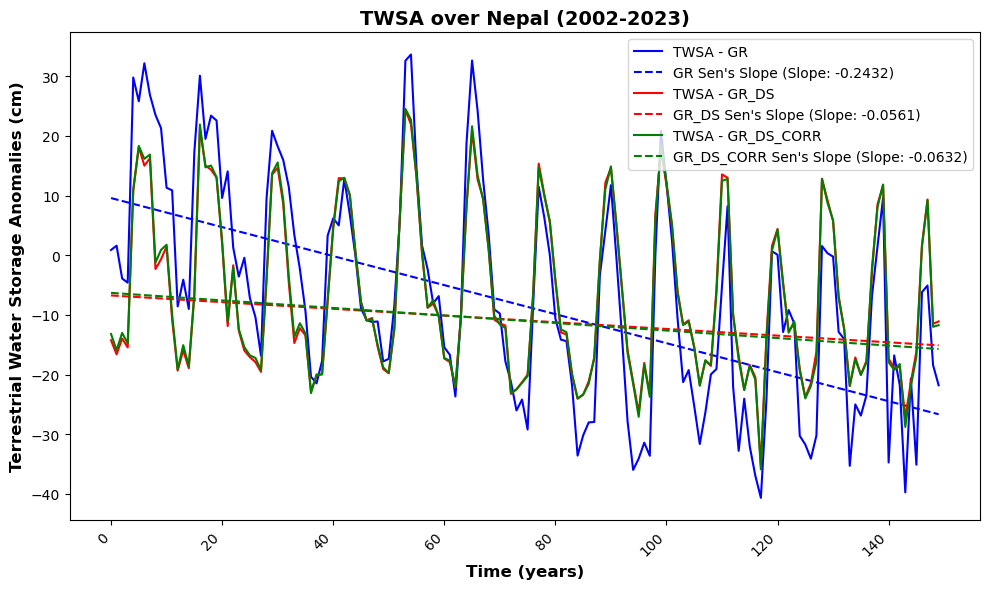

Dataset 1:
Sen's Slope: -0.2432
95% Confidence Interval: (-0.3044, -0.1853)

Dataset 2:
Sen's Slope: -0.0561
95% Confidence Interval: (-0.1034, -0.0147)

Dataset 3:
Sen's Slope: -0.0632
95% Confidence Interval: (-0.1109, -0.0214)


In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Calculate mean and convert to DataFrame for the first dataset
mean = GR.mean(dim=['y', 'x'])
mean_df = mean.to_dataframe()
x1 = np.arange(len(mean_df))
y1 = mean_df['lwe_thickness'].values

# Calculate Sen's slope for the first dataset
sen_slope1, intercept1, lower_slope1, upper_slope1 = stats.theilslopes(y1, x1)

# Calculate mean and convert to DataFrame for the second dataset
mean_ds = GR_DS.mean(dim=['y', 'x'])
mean_ds_df = mean_ds.to_dataframe()
x2 = np.arange(len(mean_ds_df))
y2 = mean_ds_df['lwe_thickness_predict'].values

# Calculate mean and convert to DataFrame for the corrected dataset
mean_ds_2 = new_lwe.mean(dim=['y', 'x'])
mean_ds_df2 = mean_ds_2.to_dataframe()
x3 = np.arange(len(mean_ds_df2))
y3 = mean_ds_df2['lwe_corrected'].values

# Calculate Sen's slope for the second dataset
sen_slope2, intercept2, lower_slope2, upper_slope2 = stats.theilslopes(y2, x2)

# Calculate Sen's slope for the third dataset
sen_slope3, intercept3, lower_slope3, upper_slope3 = stats.theilslopes(y3, x3)

# Create a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate correlation between the two datasets
correlation, p_value = stats.pearsonr(y1, y2)
print(f"Pearson Correlation between original and DS: {correlation:.4f}")
print(f"P-value original and DS: {p_value:.4f}")

# Calculate correlation between the two datasets
correlation2, p_value2 = stats.pearsonr(y1, y3)
print(f"Pearson Correlation between original and DS: {correlation2:.4f}")
print(f"P-value original and DS: {p_value2:.4f}")

# Convert the index to matplotlib-compatible format
# This line converts the DateTimeIndex to a list of strings
x_values = [str(date) for date in mean_ds_df.index]


# Plot the first dataset and its trendline
# Note: Using x1 here for the x-axis values
ax.plot(x1, y1, marker='', linestyle='-', color='b', label='TWSA - GR')
trendline1 = sen_slope1 * x1 + intercept1
ax.plot(x1, trendline1, linestyle='--', color='b', label=f"GR Sen's Slope (Slope: {sen_slope1:.4f})")

# Plot the second dataset and its trendline
# Note: Using x2 here for the x-axis values
ax.plot(x2, y2, marker='', linestyle='-', color='r', label='TWSA - GR_DS')
trendline2 = sen_slope2 * x2 + intercept2
ax.plot(x2, trendline2, linestyle='--', color='r', label=f"GR_DS Sen's Slope (Slope: {sen_slope2:.4f})")

# Plot the third dataset and its trendline
# Note: Using x3 here for the x-axis values
ax.plot(x3, y3, marker='', linestyle='-', color='g', label='TWSA - GR_DS_CORR')
trendline3 = sen_slope3 * x3 + intercept3
ax.plot(x3, trendline3, linestyle='--', color='g', label=f"GR_DS_CORR Sen's Slope (Slope: {sen_slope3:.4f})")

# Customize the plot
ax.set_xlabel('Time (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Terrestrial Water Storage Anomalies (cm)', fontsize=12, fontweight='bold')
ax.set_title("TWSA over Nepal (2002-2023)", fontsize=14, fontweight='bold')
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

# Print Sen's slopes and confidence intervals
print("Dataset 1:")
print(f"Sen's Slope: {sen_slope1:.4f}")
print(f"95% Confidence Interval: ({lower_slope1:.4f}, {upper_slope1:.4f})")

print("\nDataset 2:")
print(f"Sen's Slope: {sen_slope2:.4f}")
print(f"95% Confidence Interval: ({lower_slope2:.4f}, {upper_slope2:.4f})")

print("\nDataset 3:")
print(f"Sen's Slope: {sen_slope3:.4f}")
print(f"95% Confidence Interval: ({lower_slope3:.4f}, {upper_slope3:.4f})")

# Graphical comparison

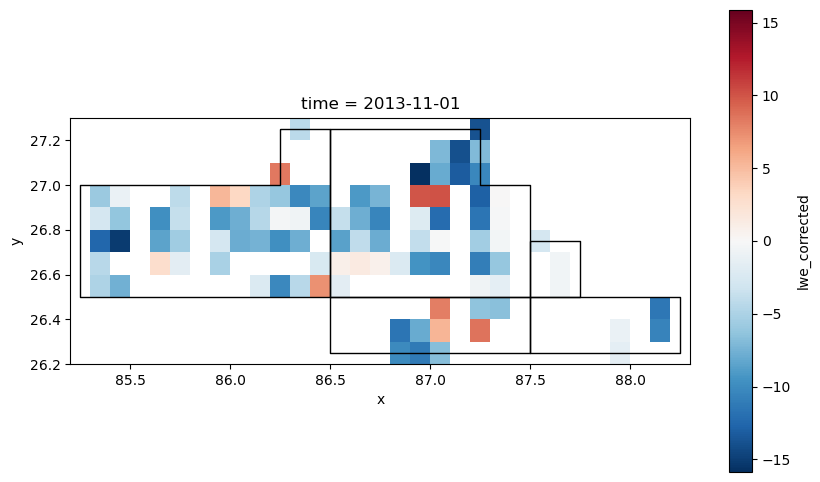

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

# Transpose the dataset to switch lat (y) and lon (x)
lwe_correct = new_lwe.lwe_corrected.isel(time=121).transpose('y', 'x')
lwe_correct.plot(ax=ax)

# Plot the shapefile
nepal_shp.plot(ax=ax, edgecolor='black', facecolor='None')

plt.show()

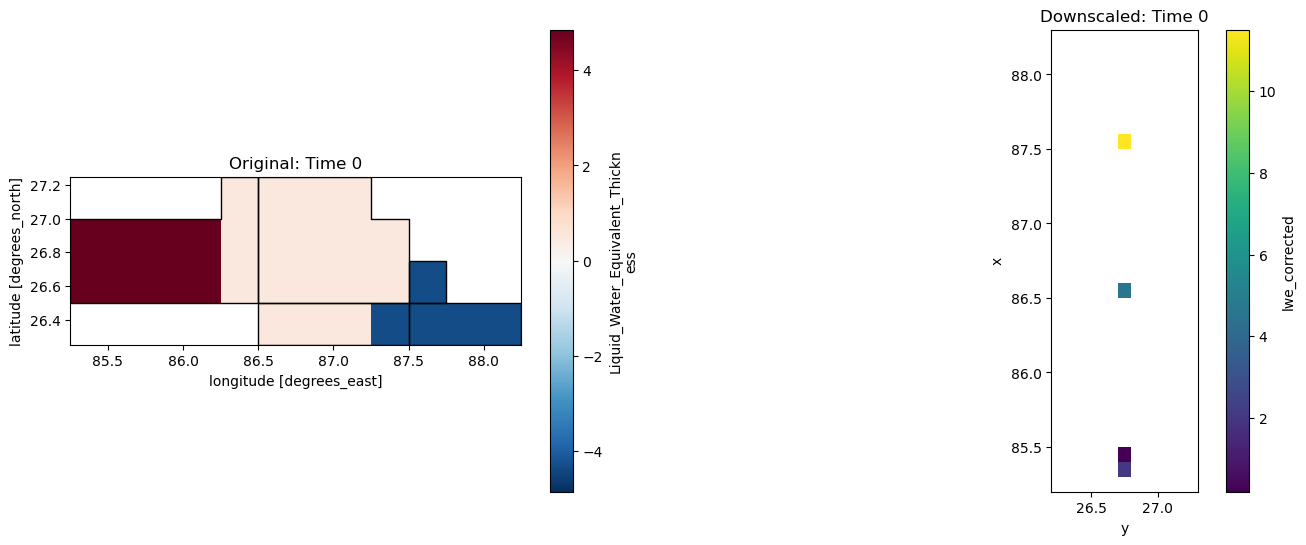

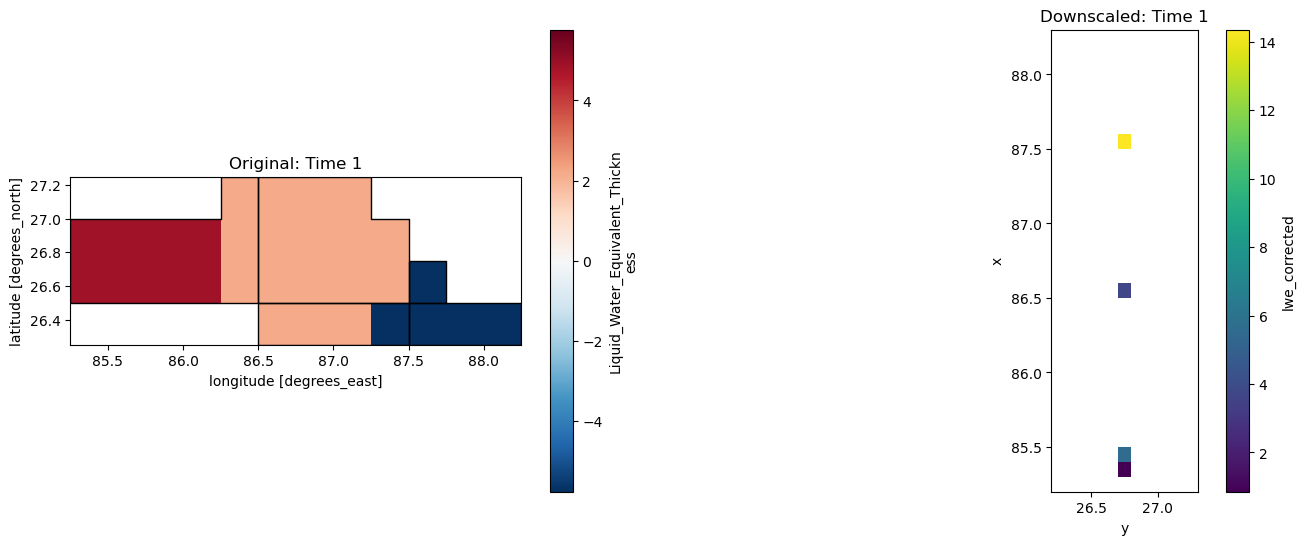

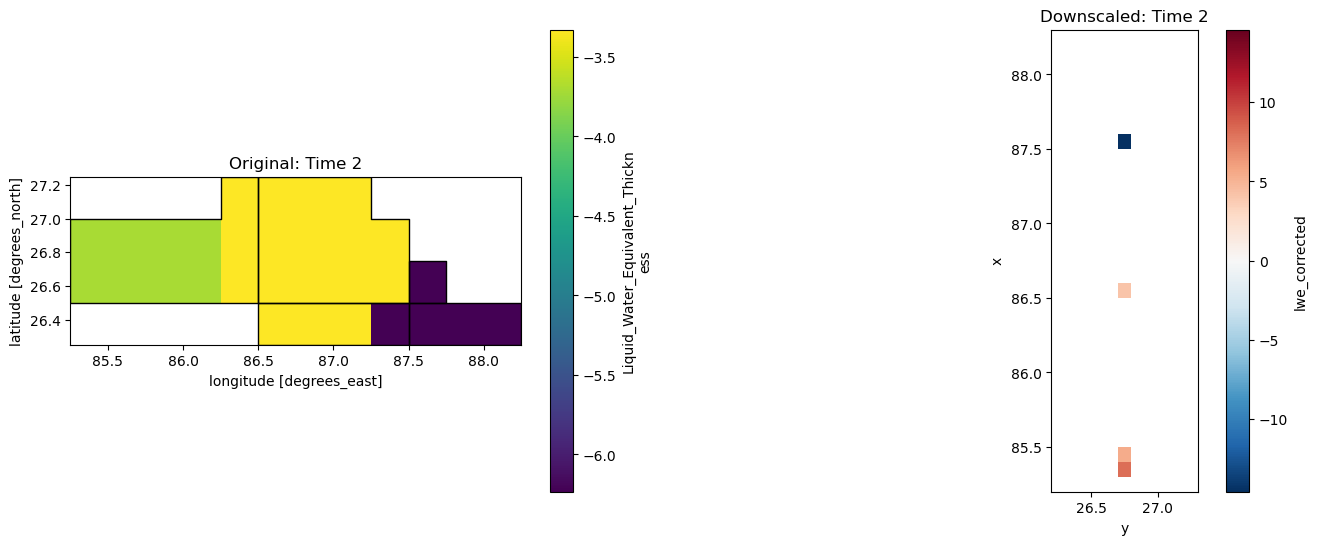

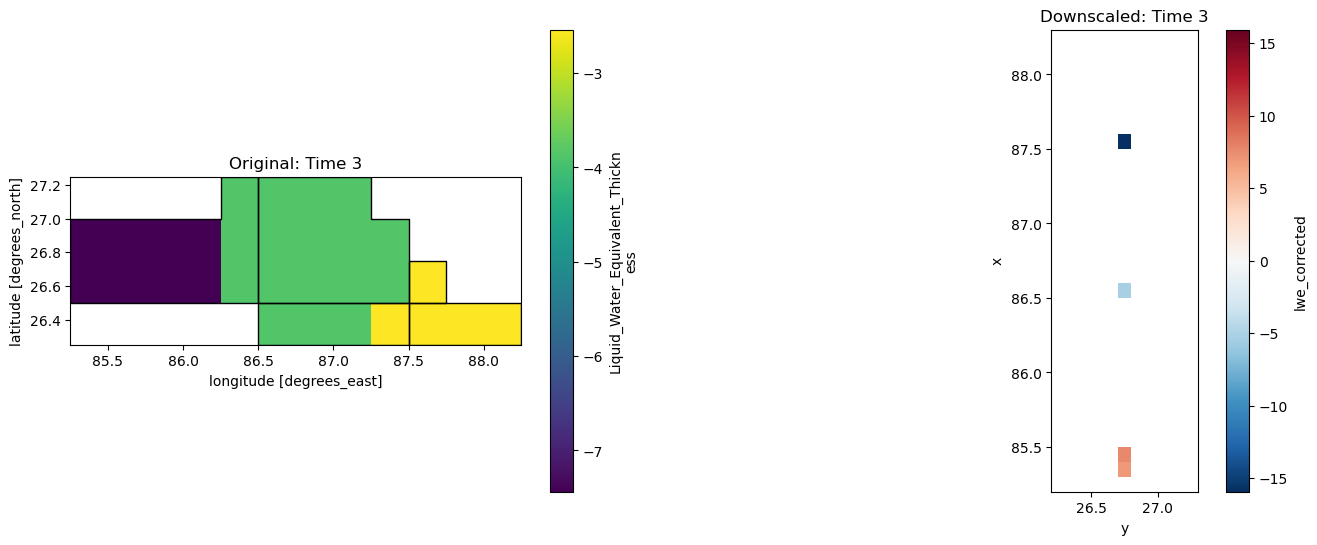

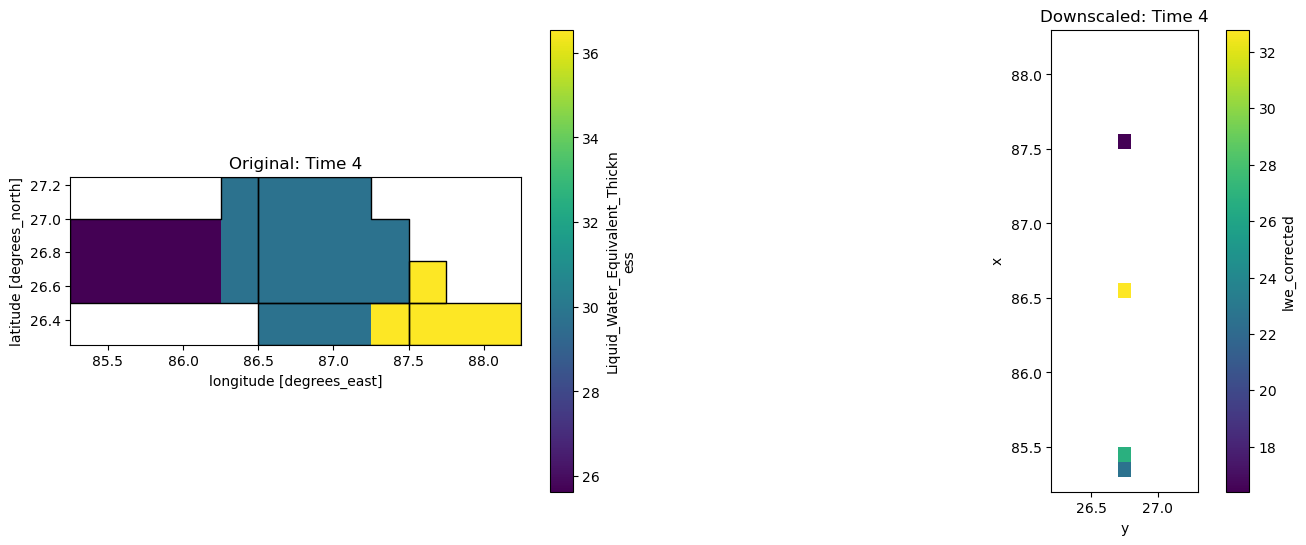

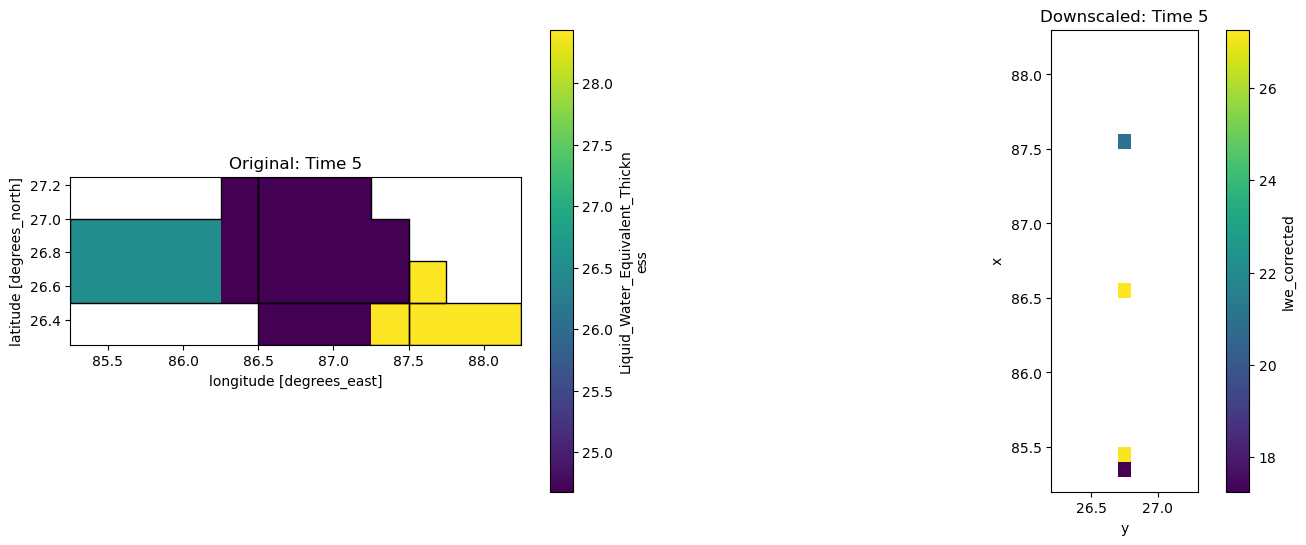

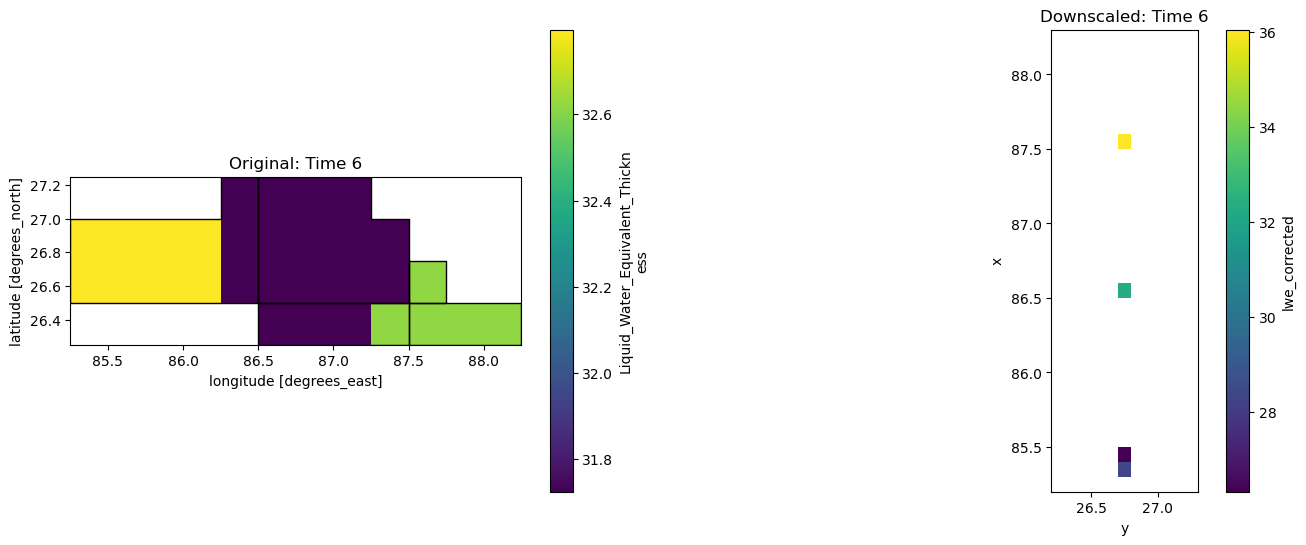

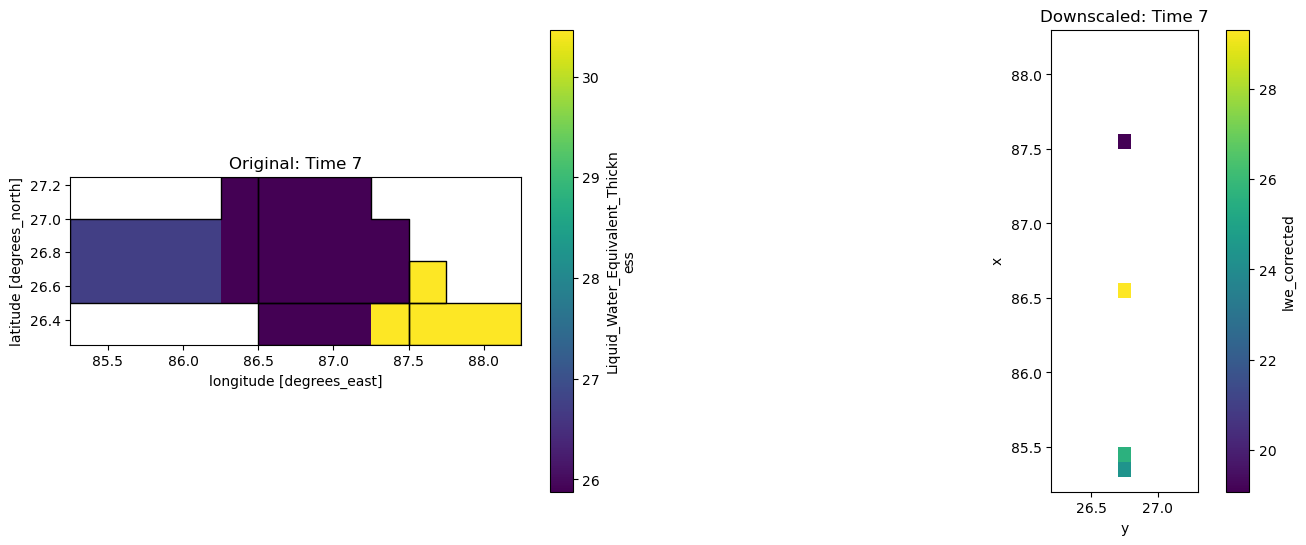

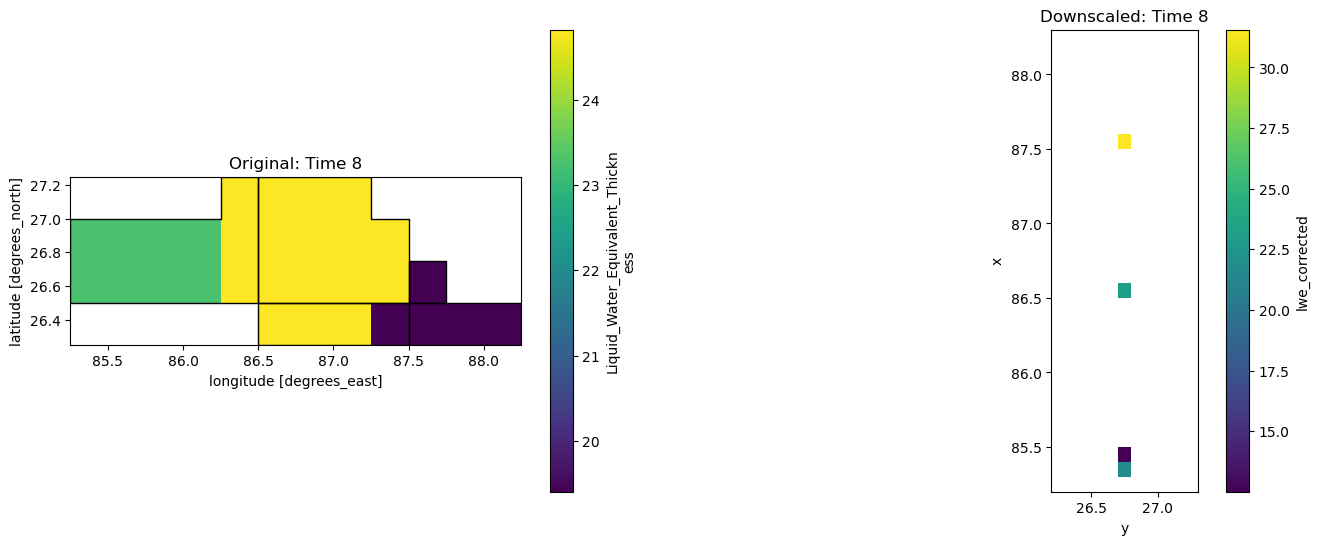

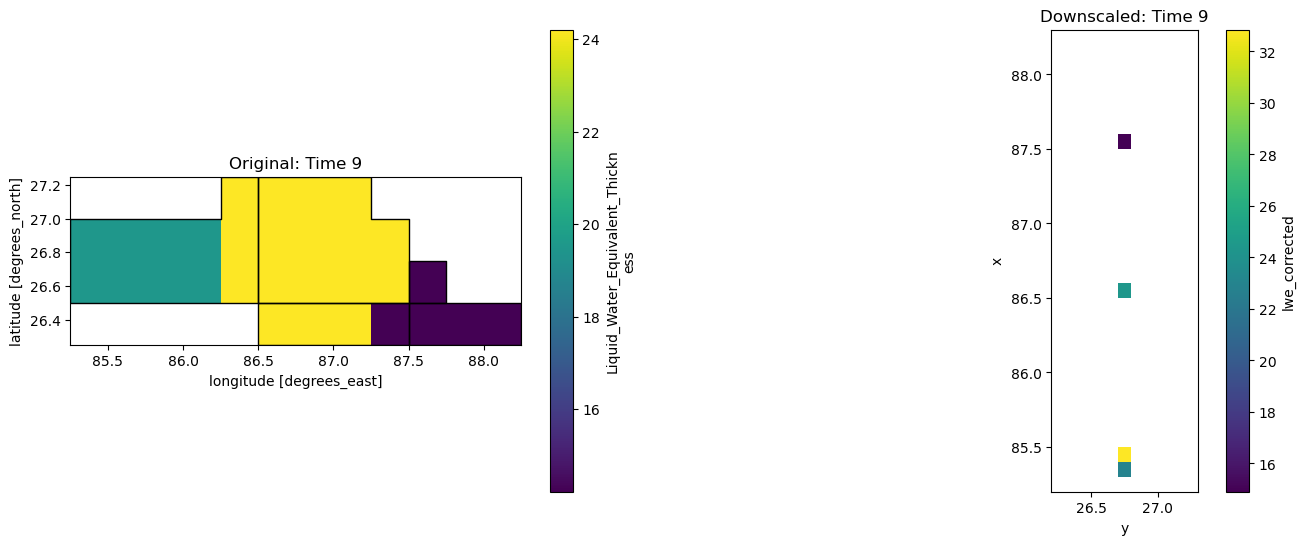

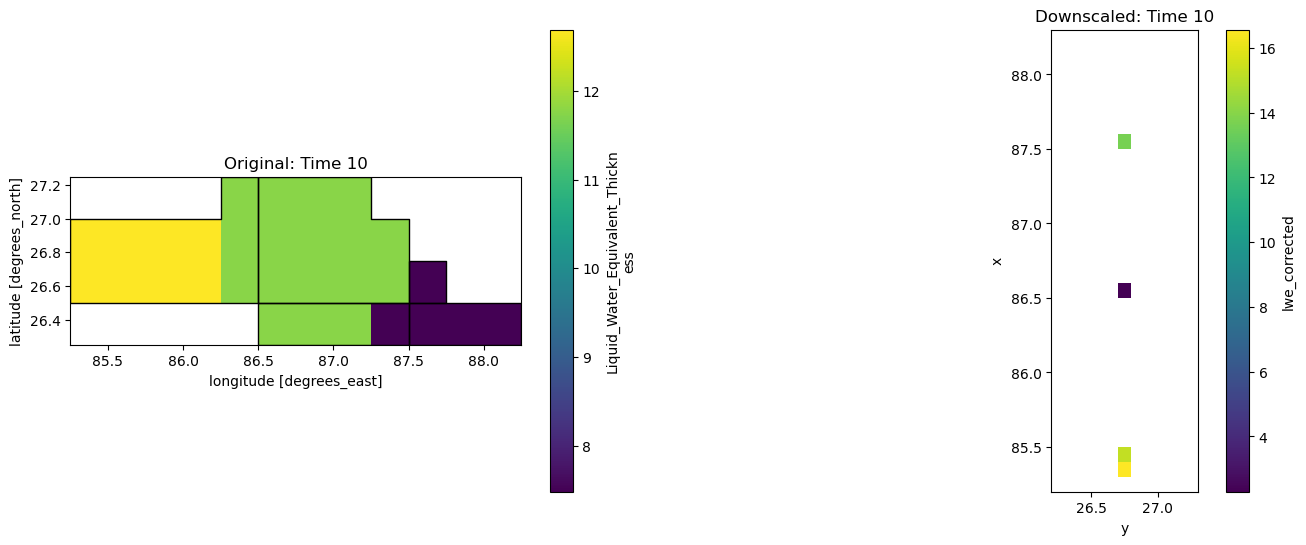

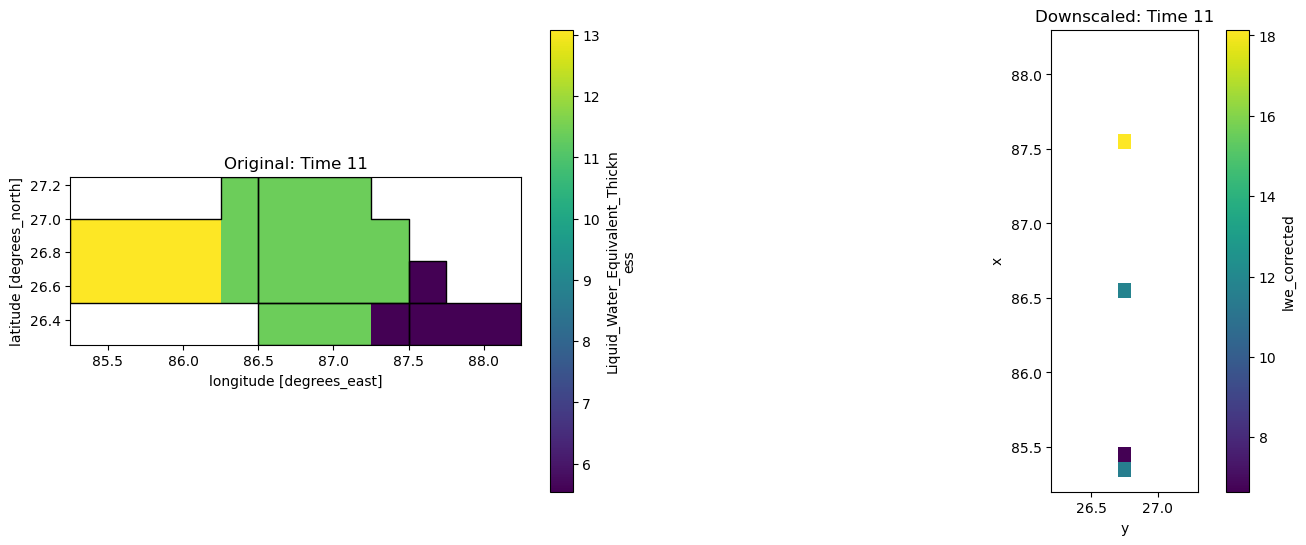

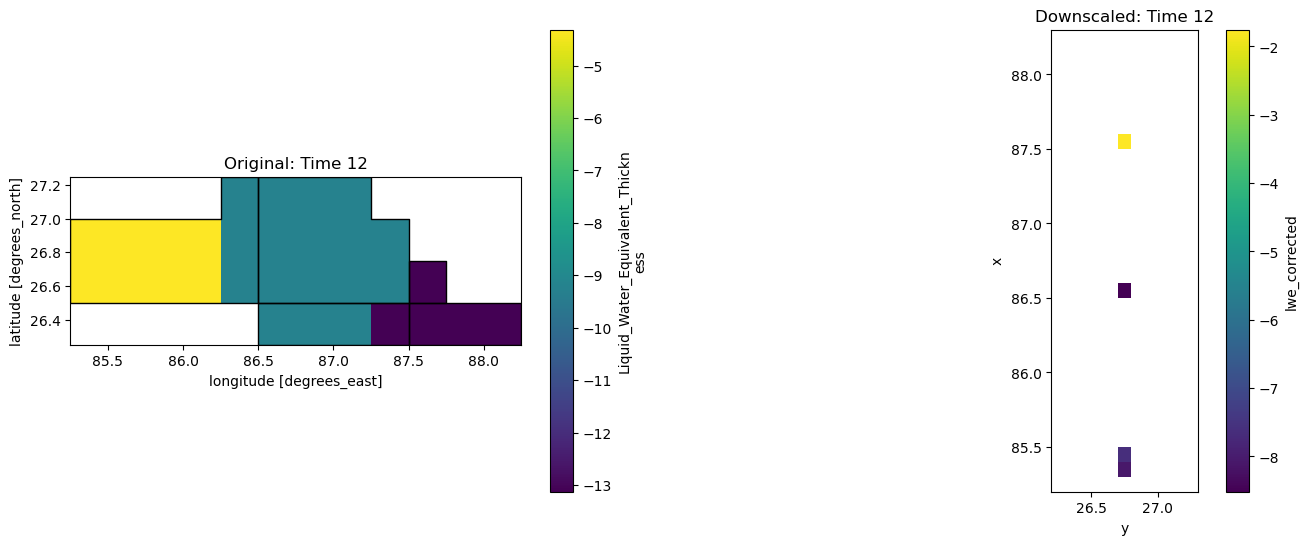

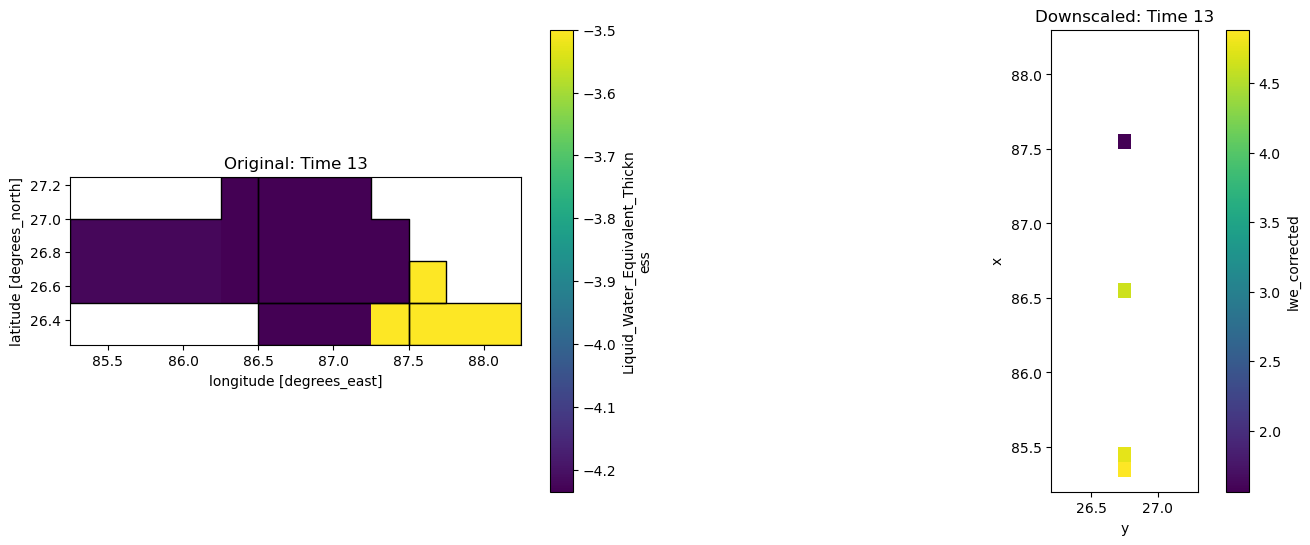

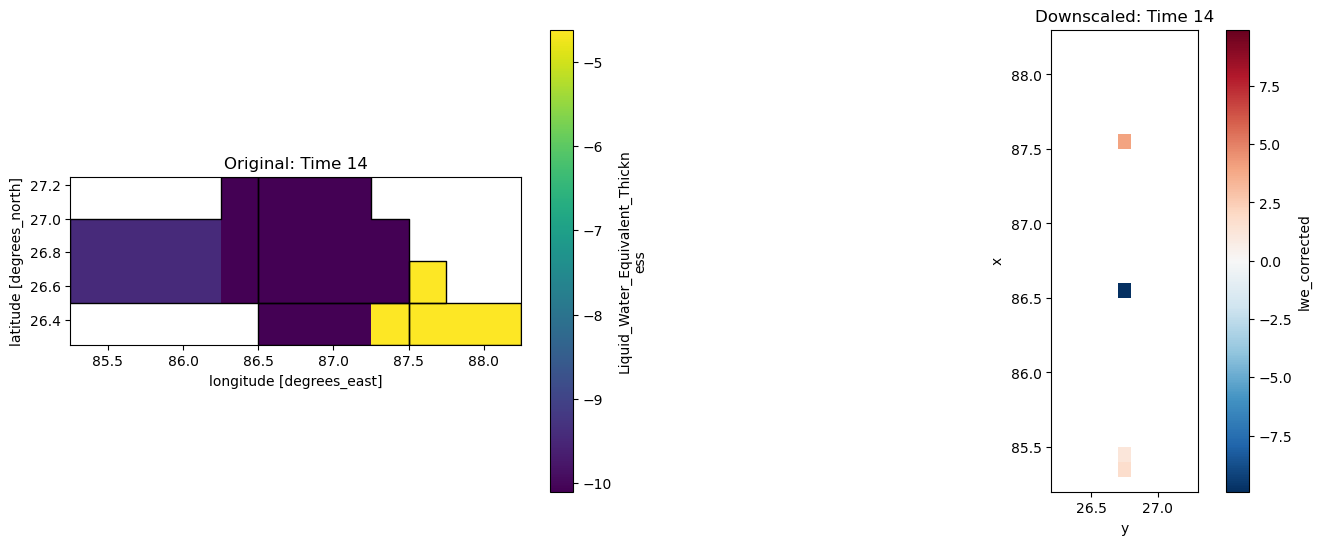

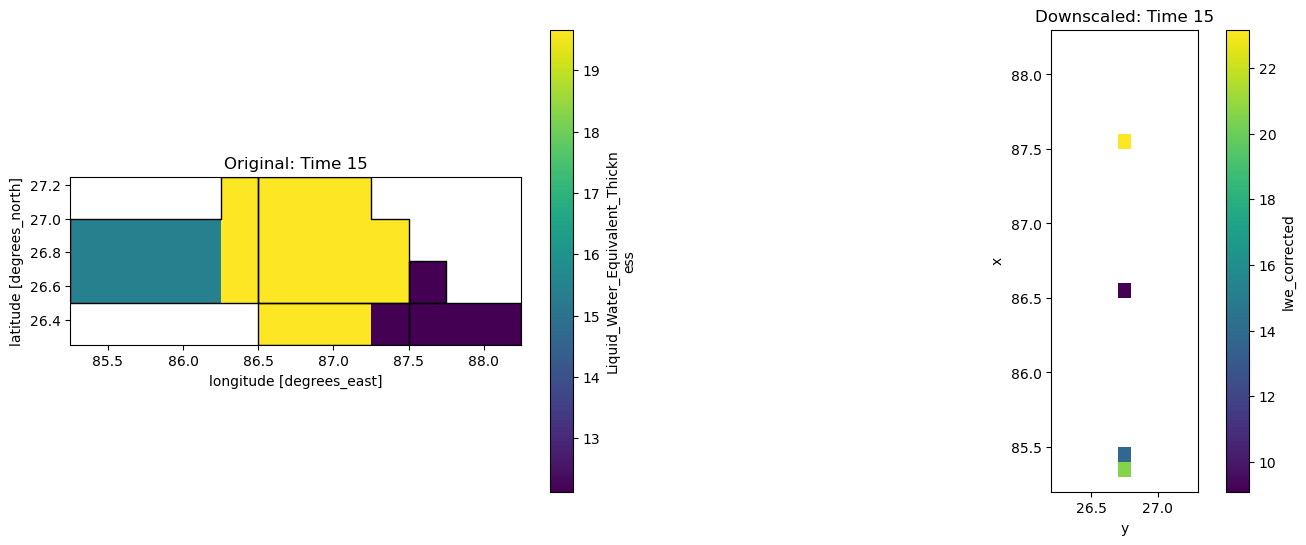

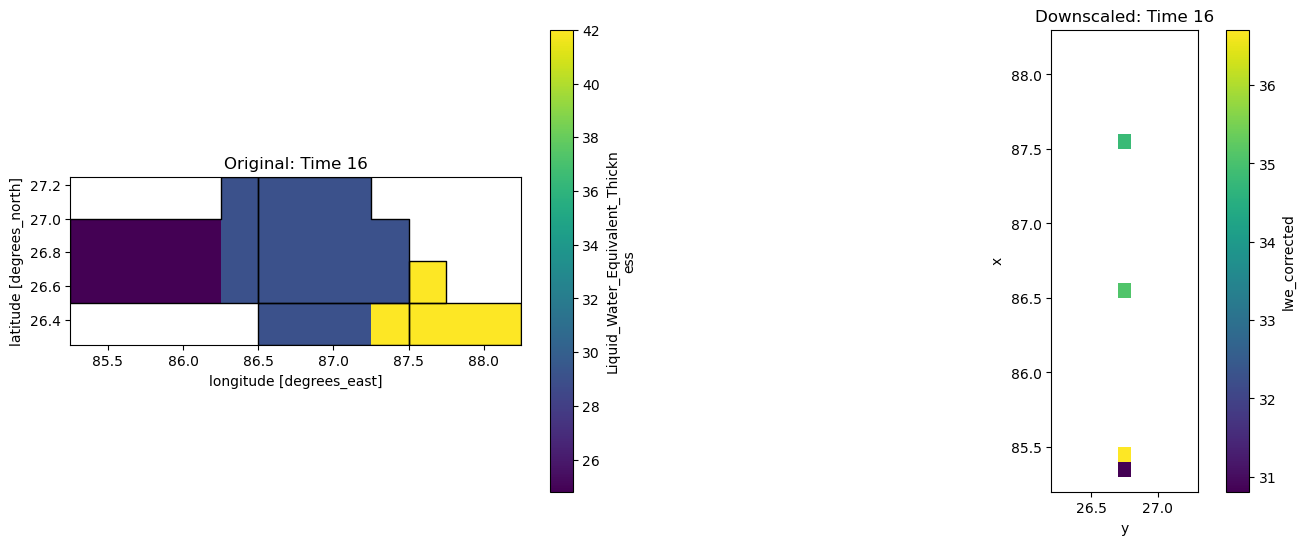

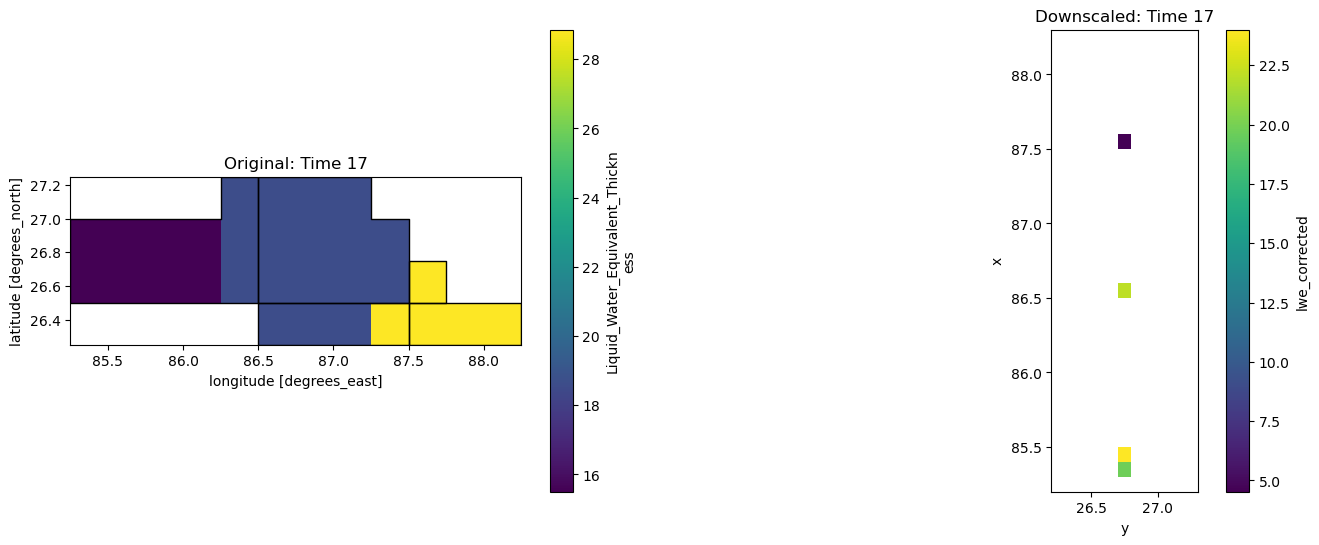

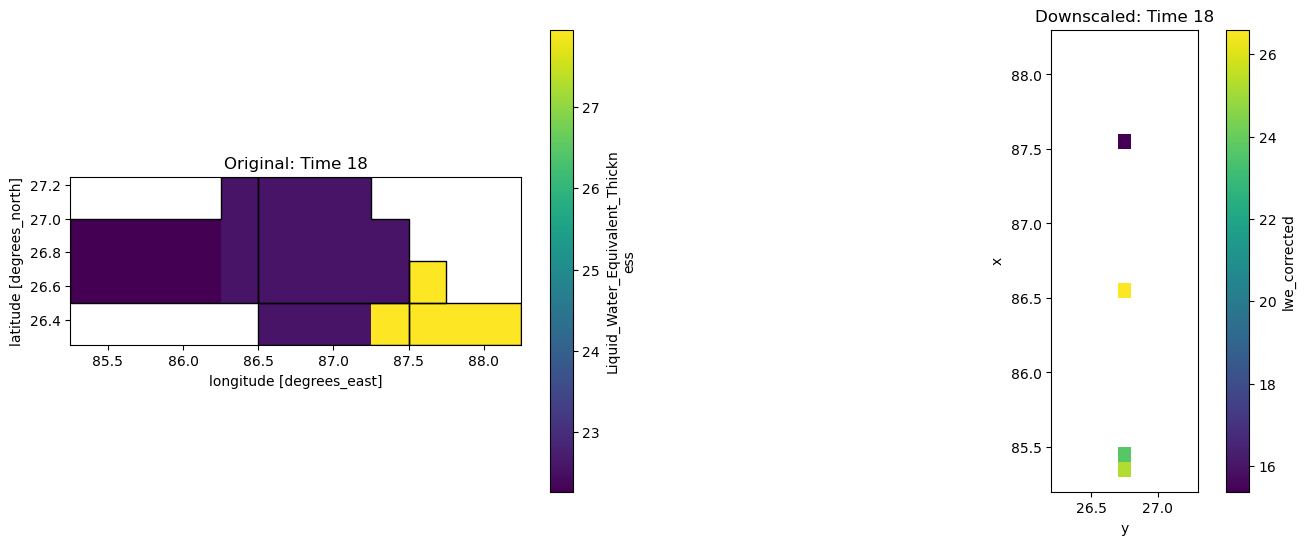

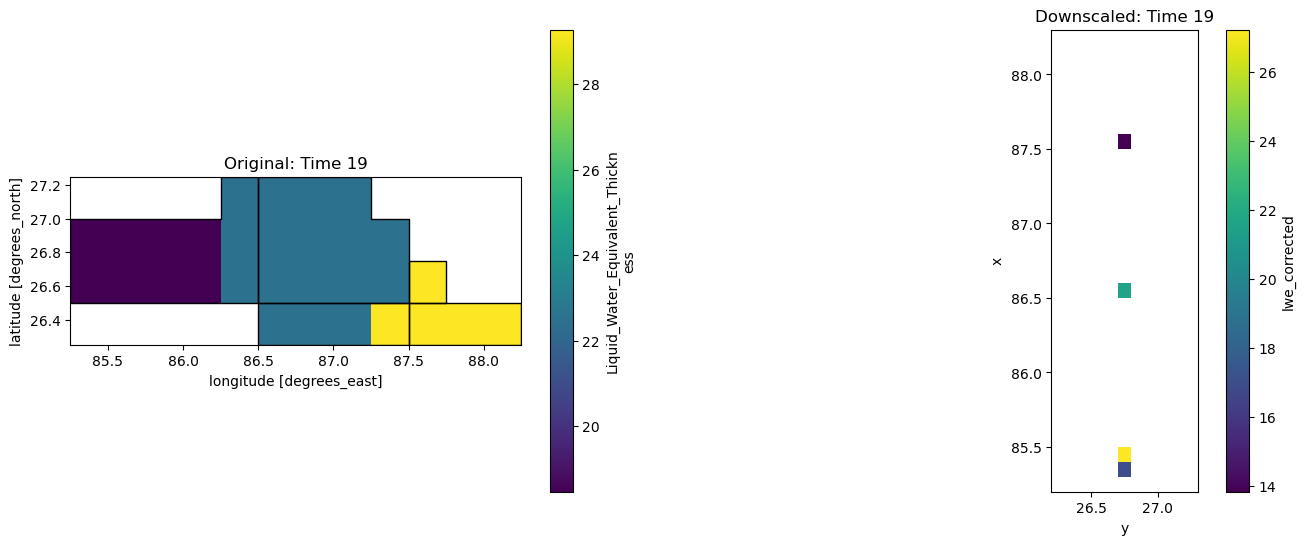

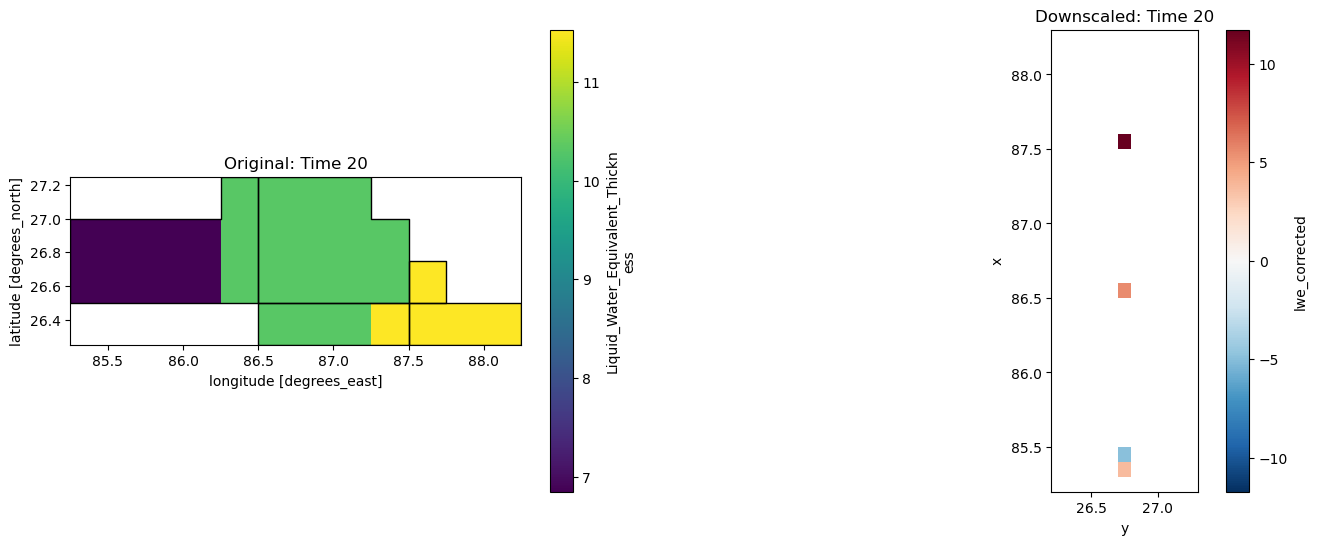

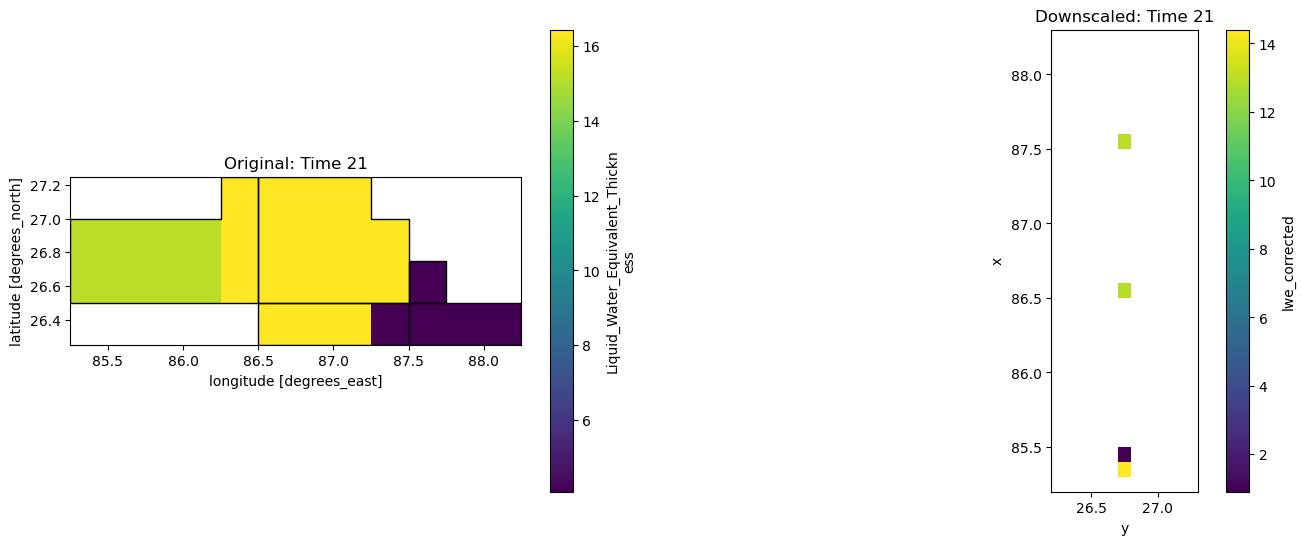

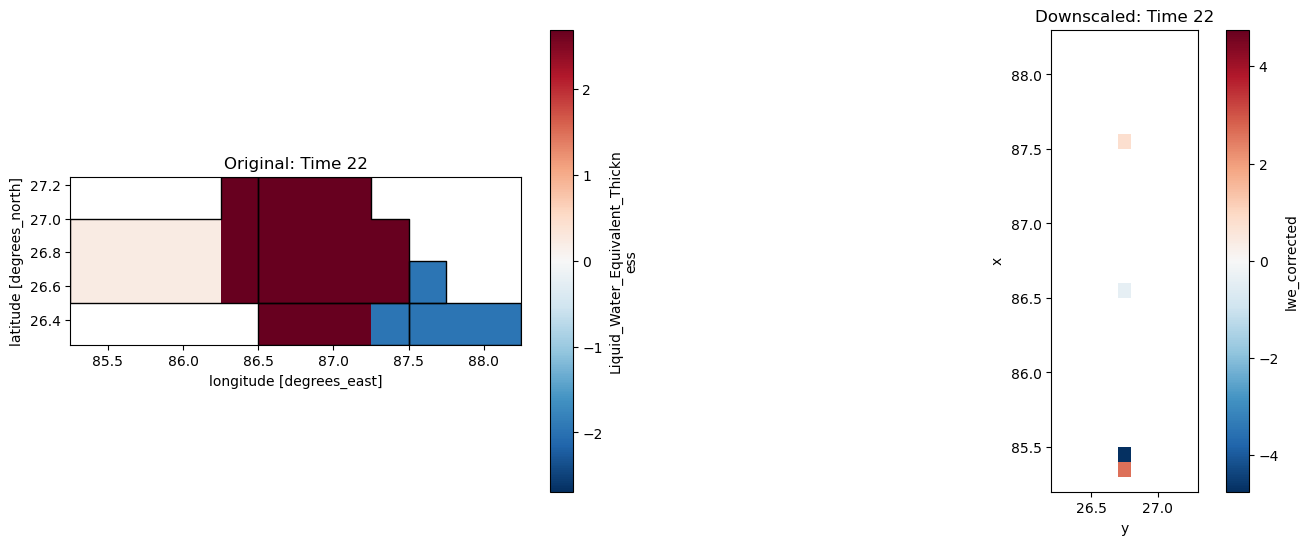

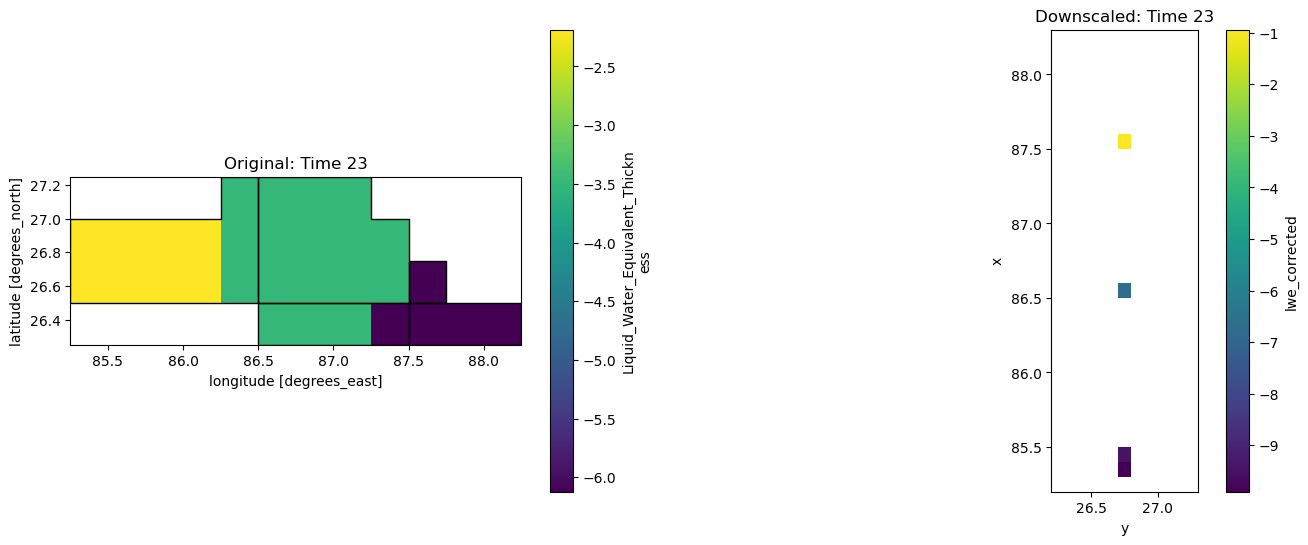

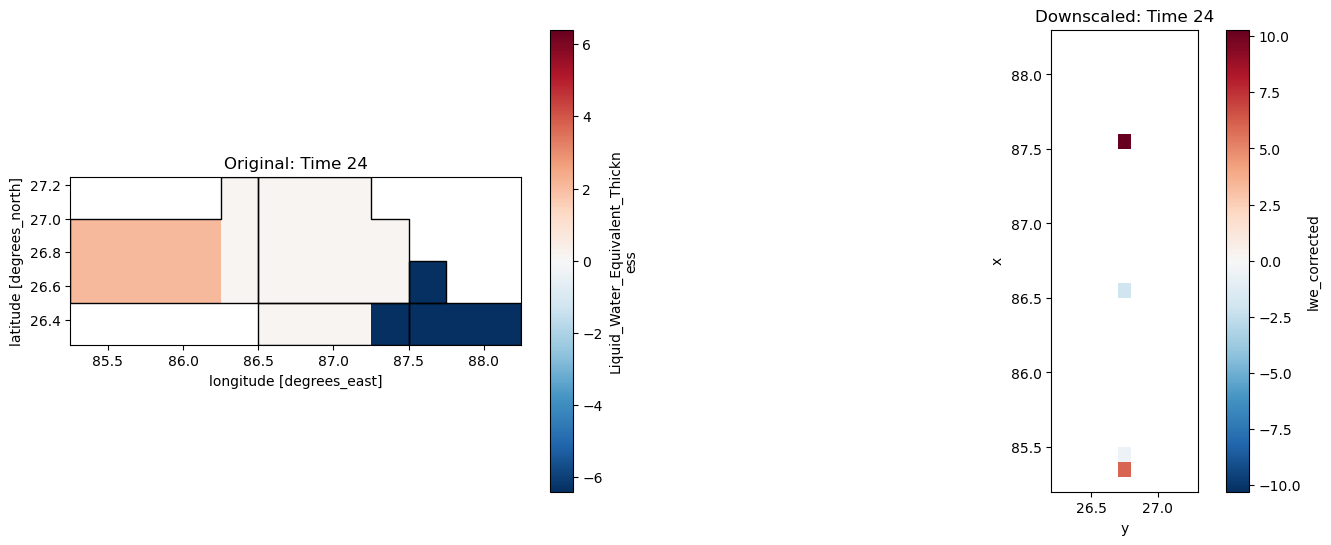

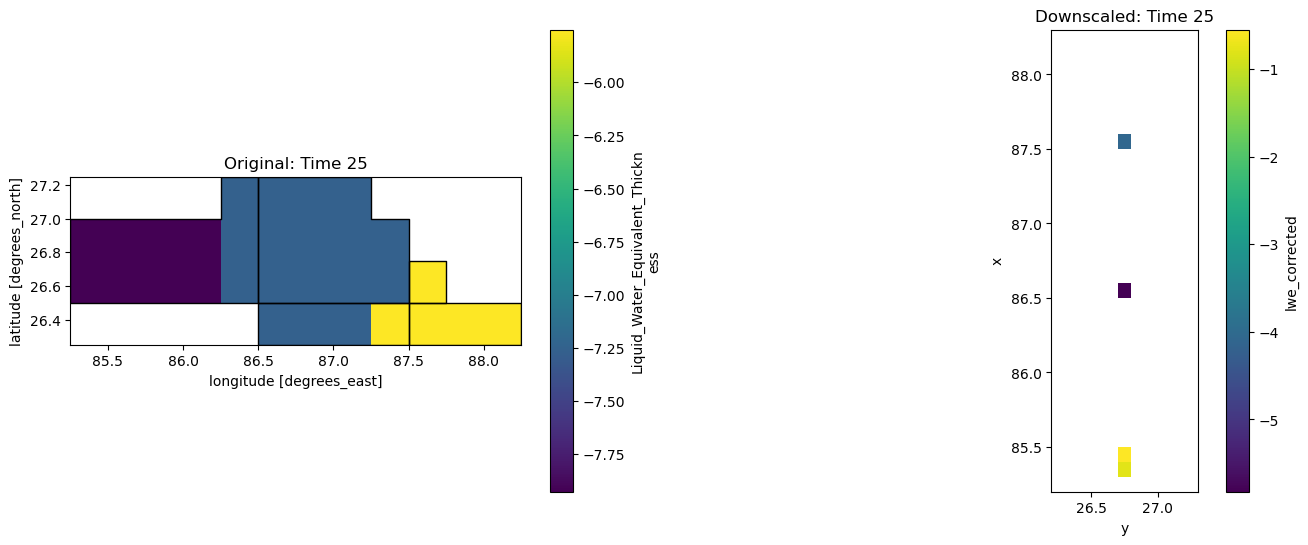

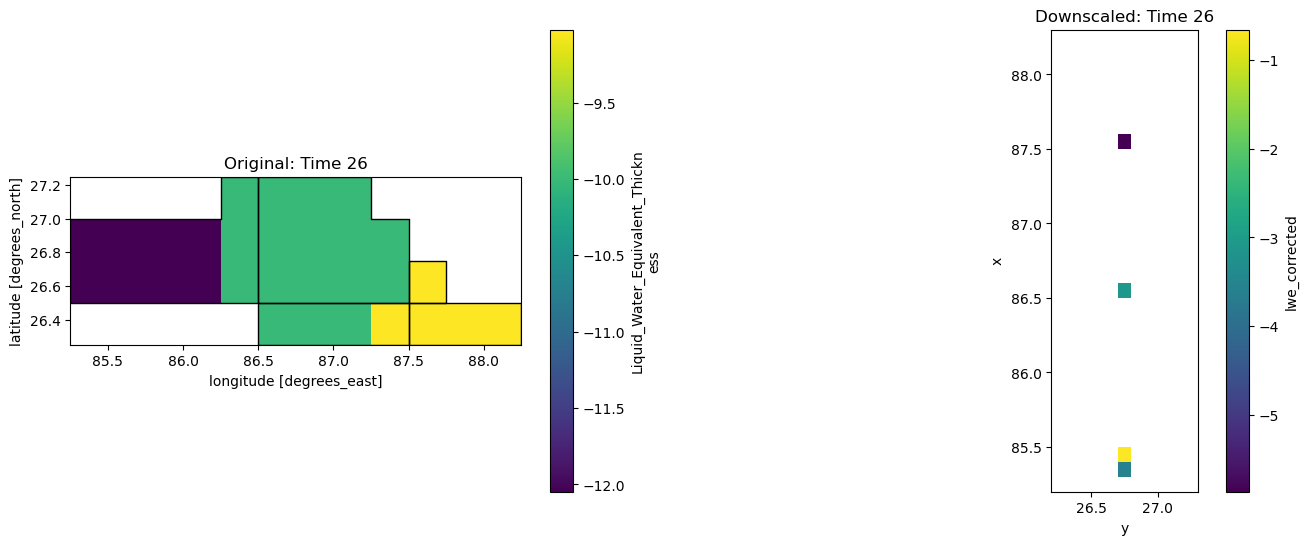

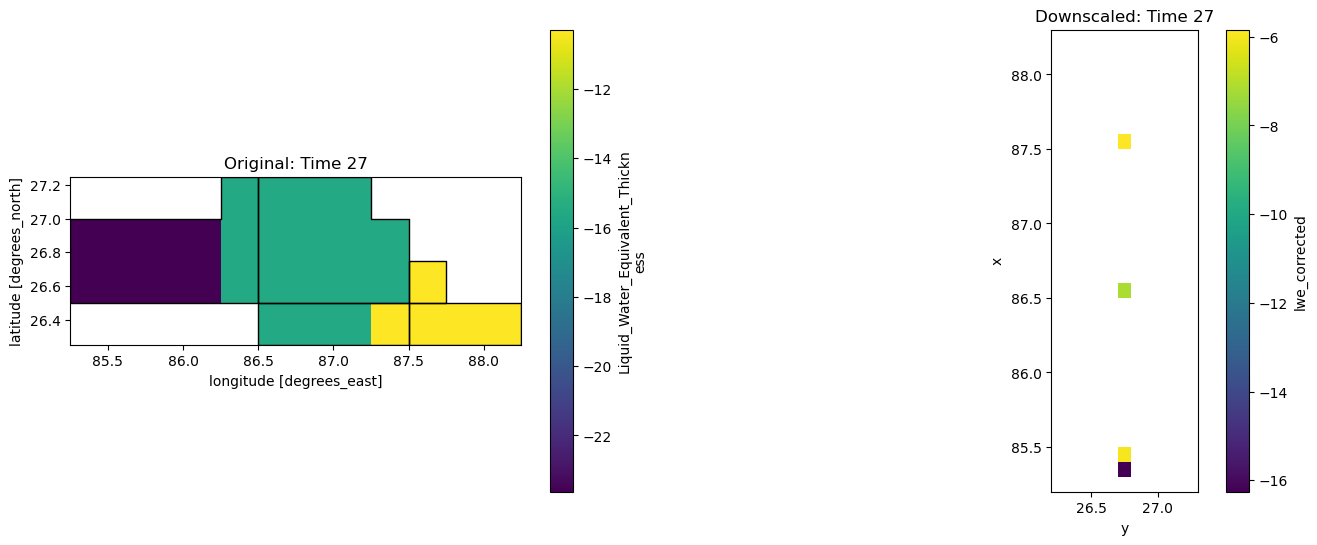

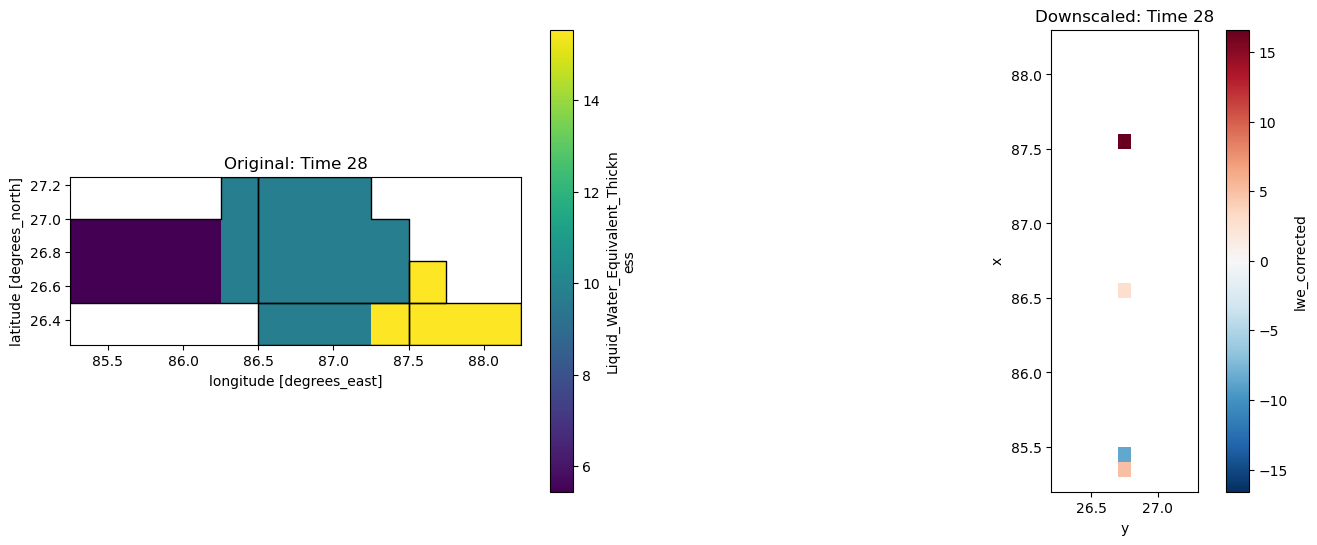

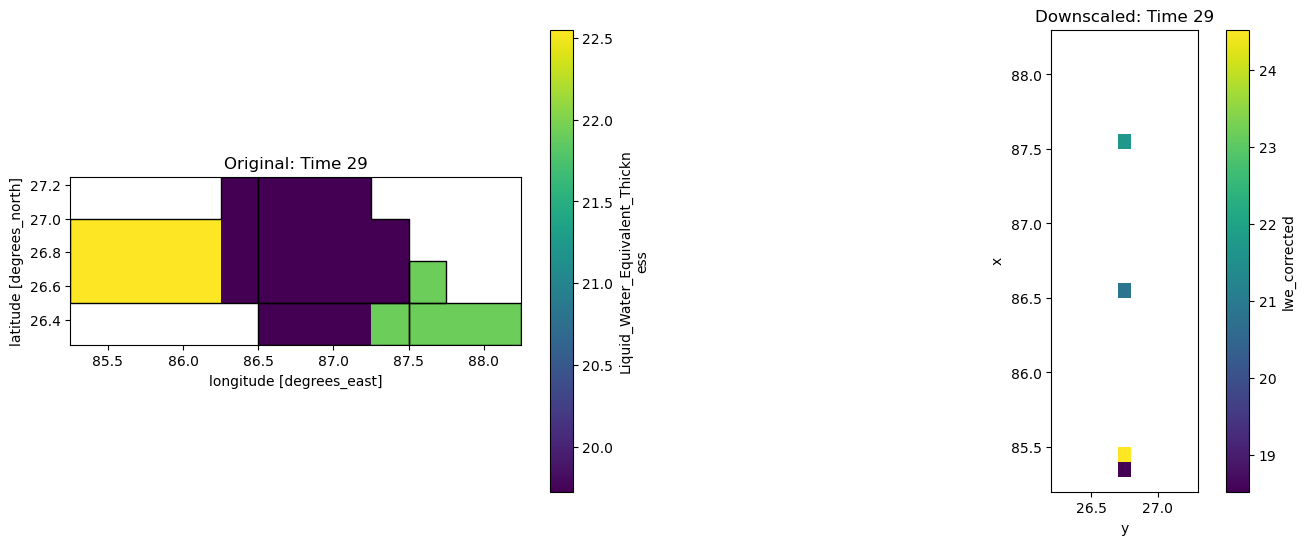

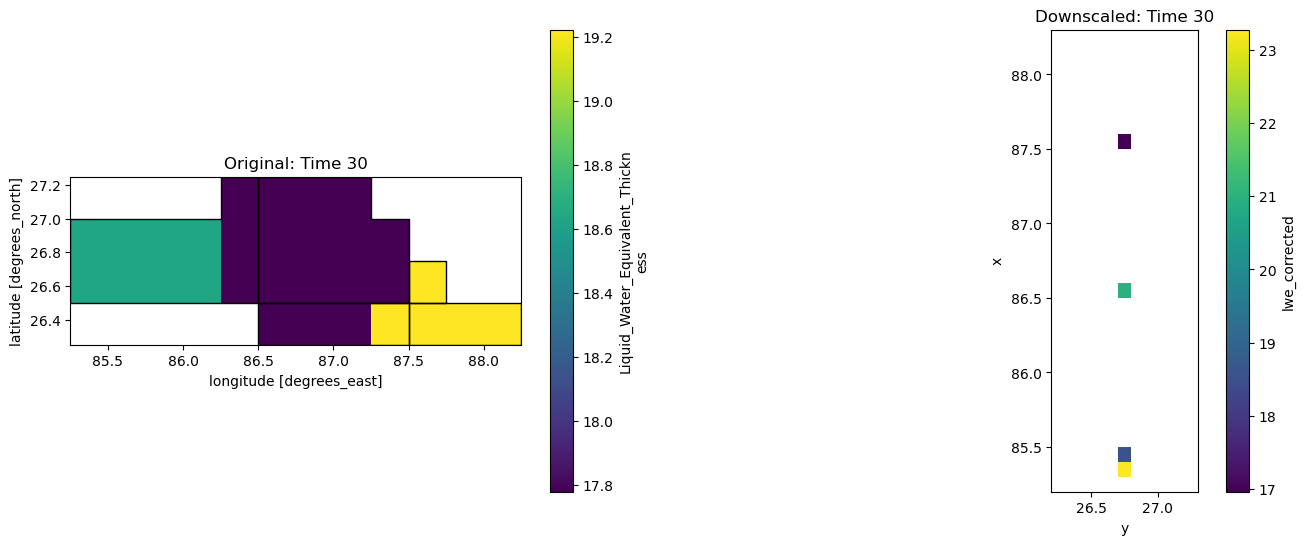

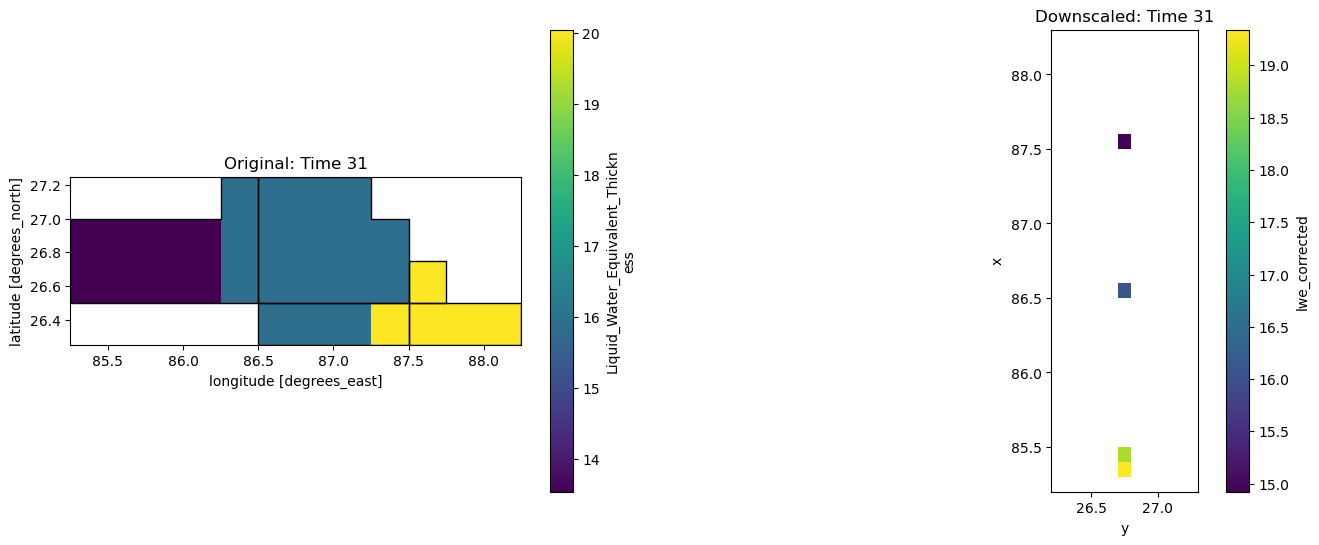

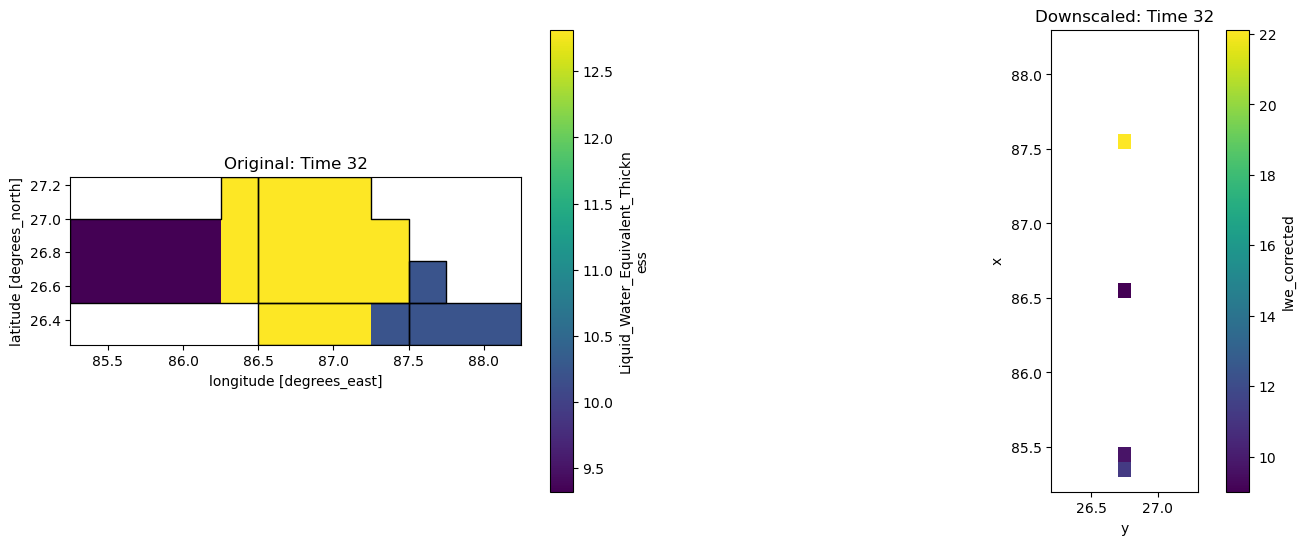

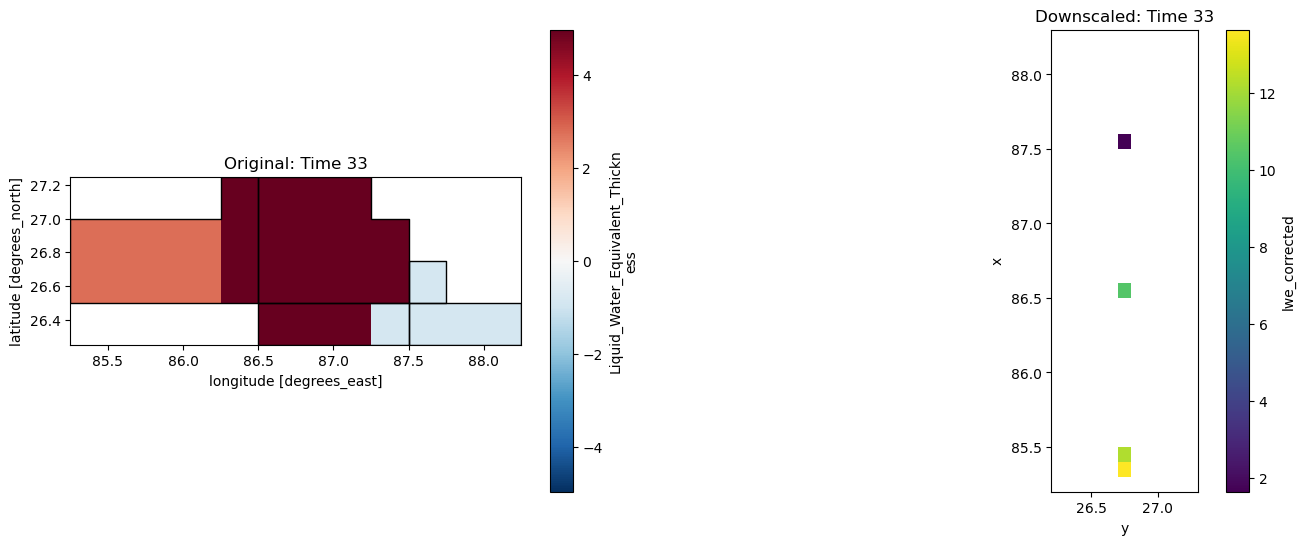

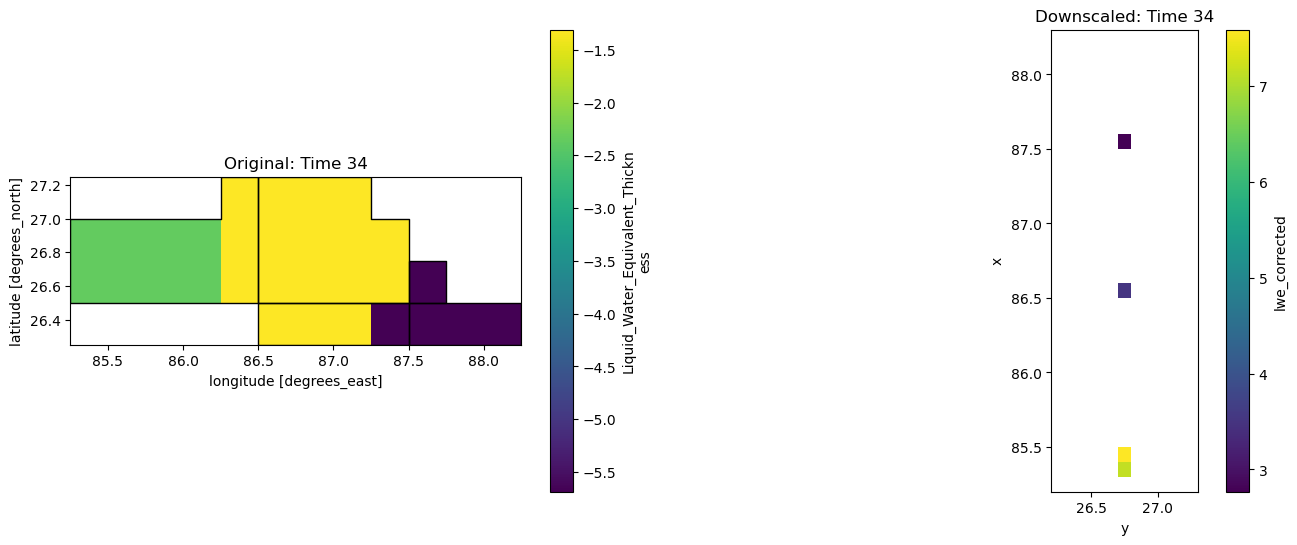

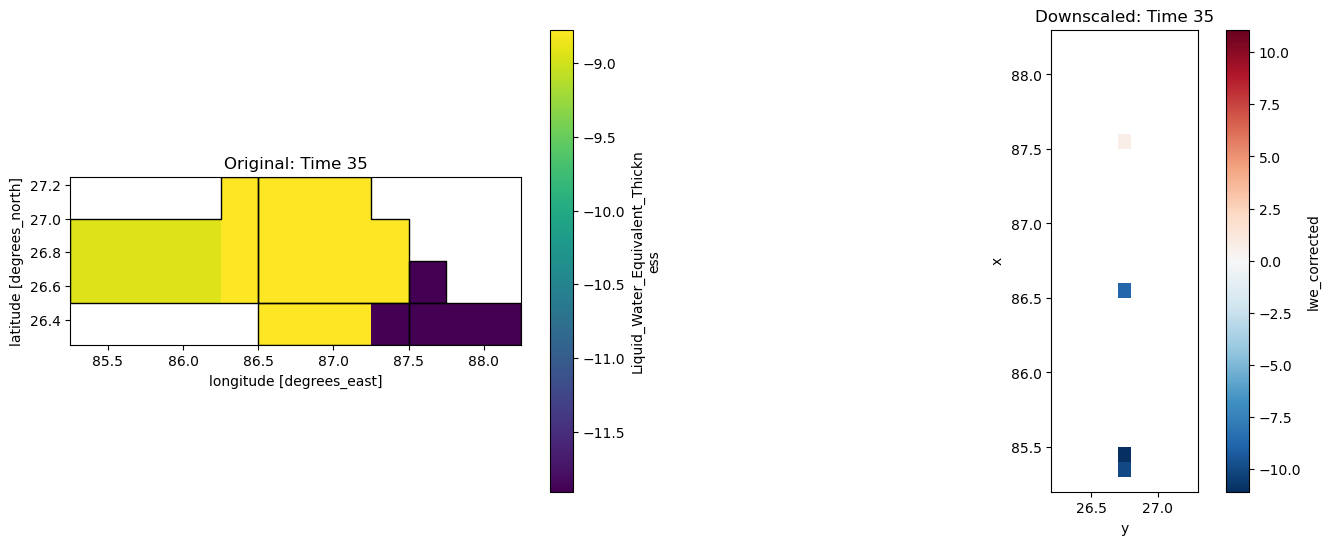

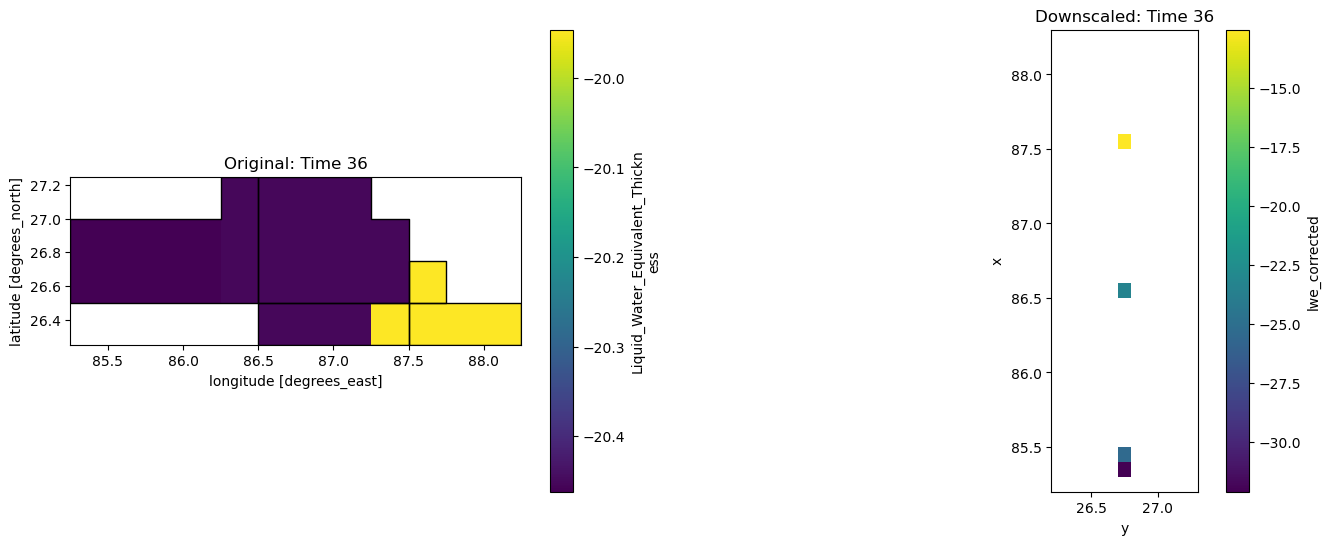

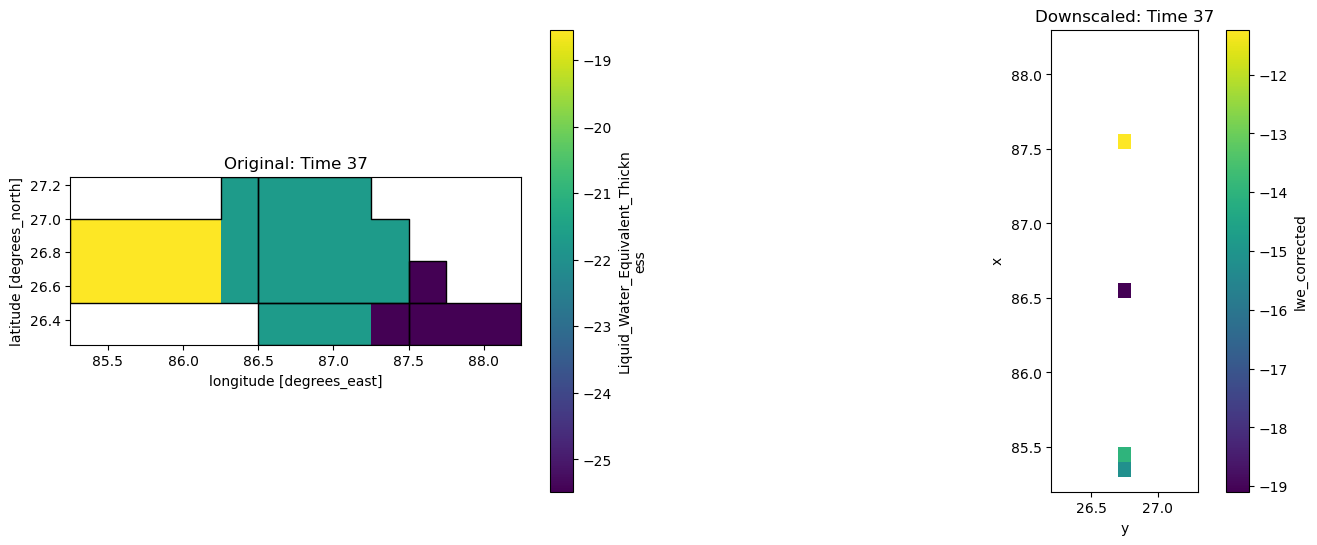

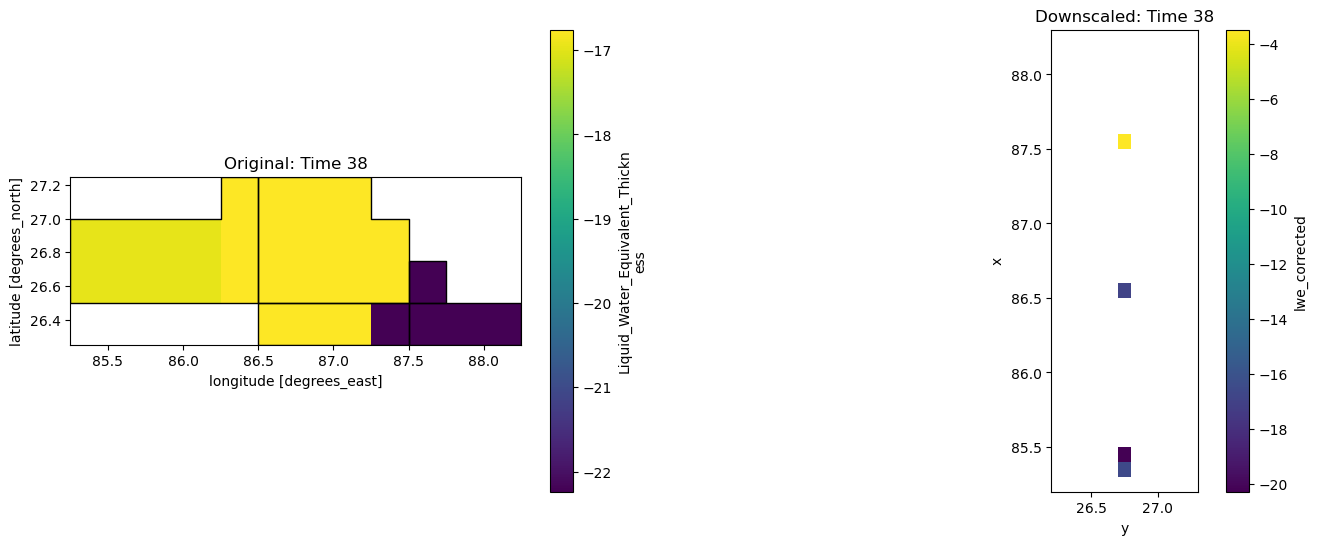

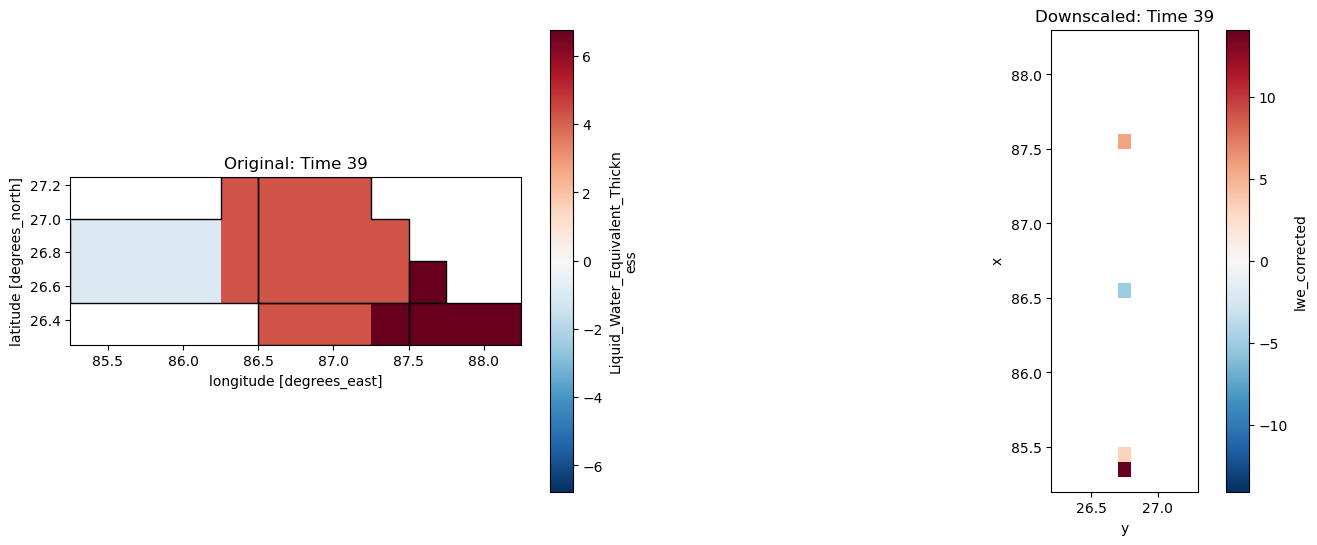

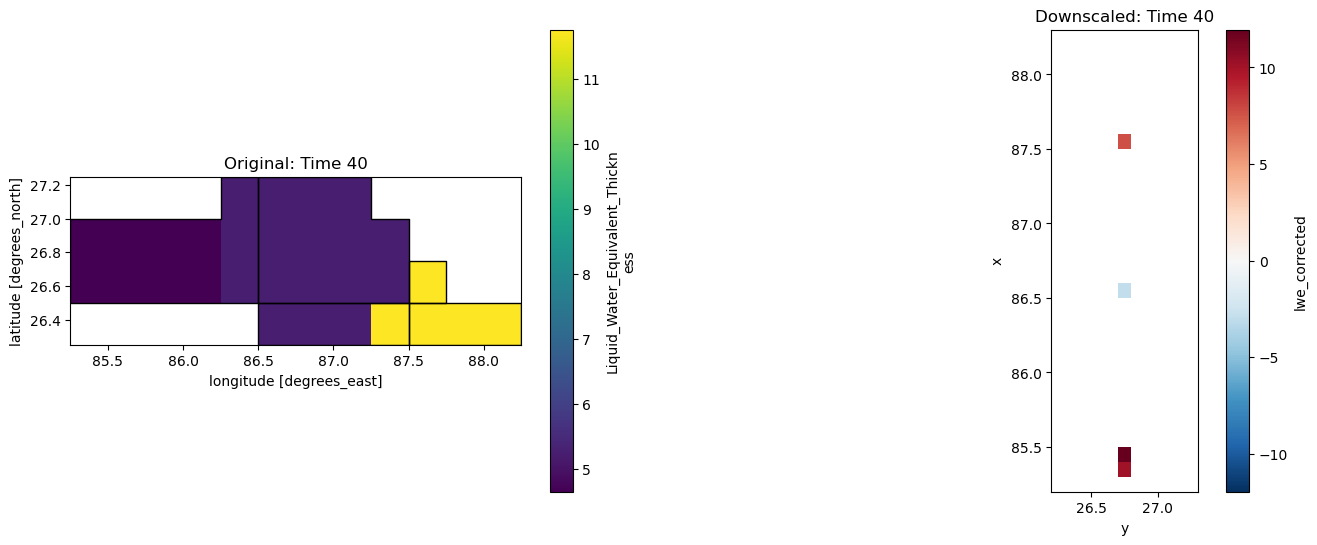

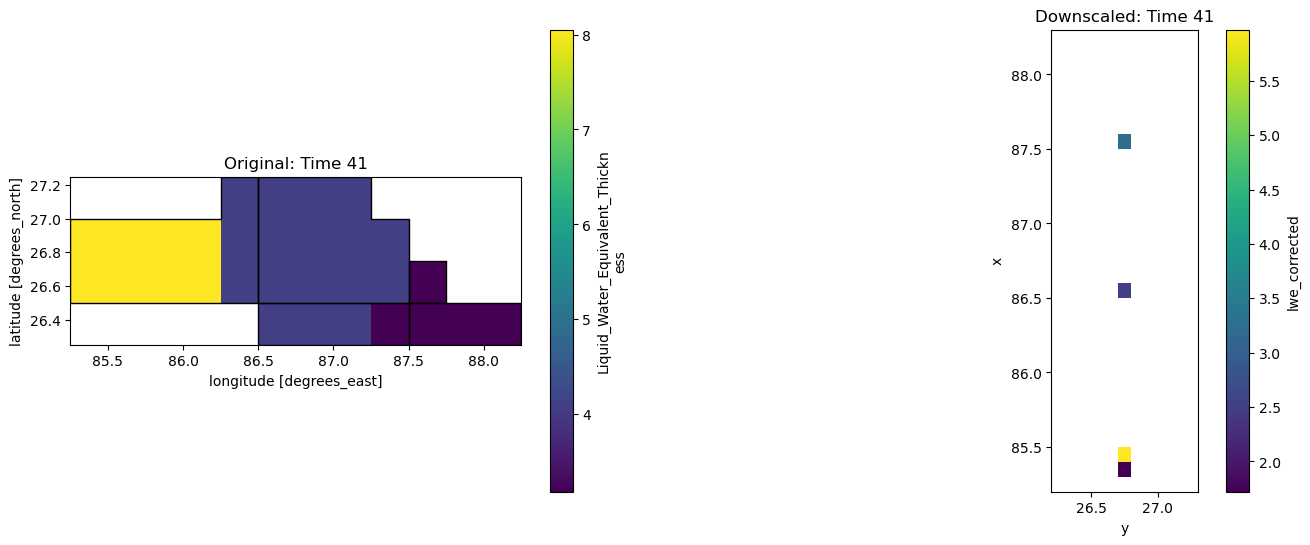

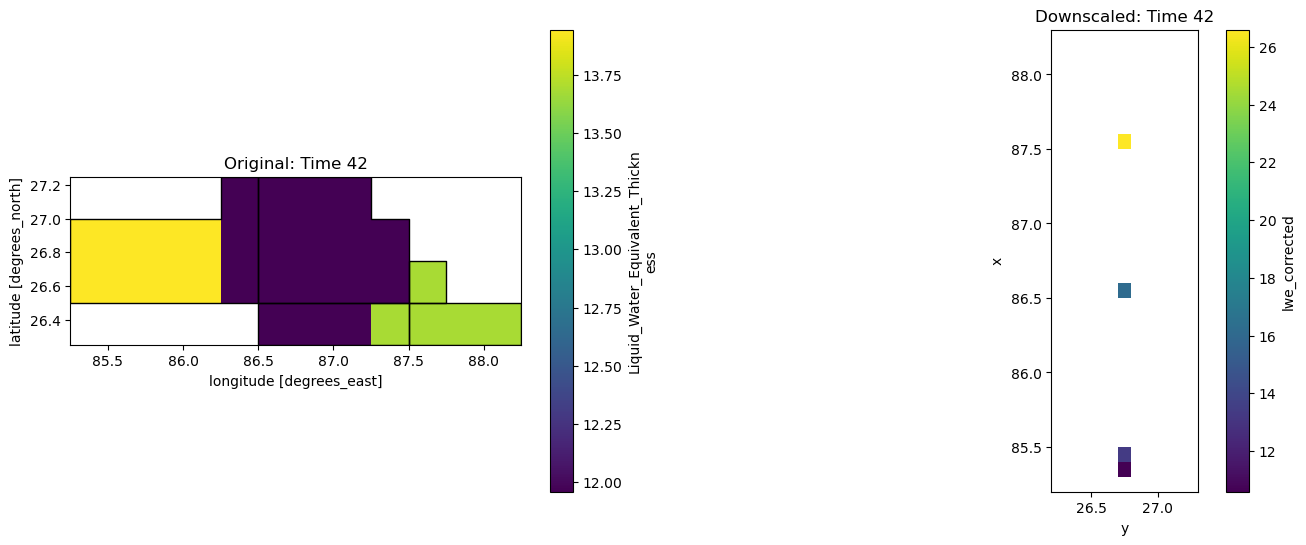

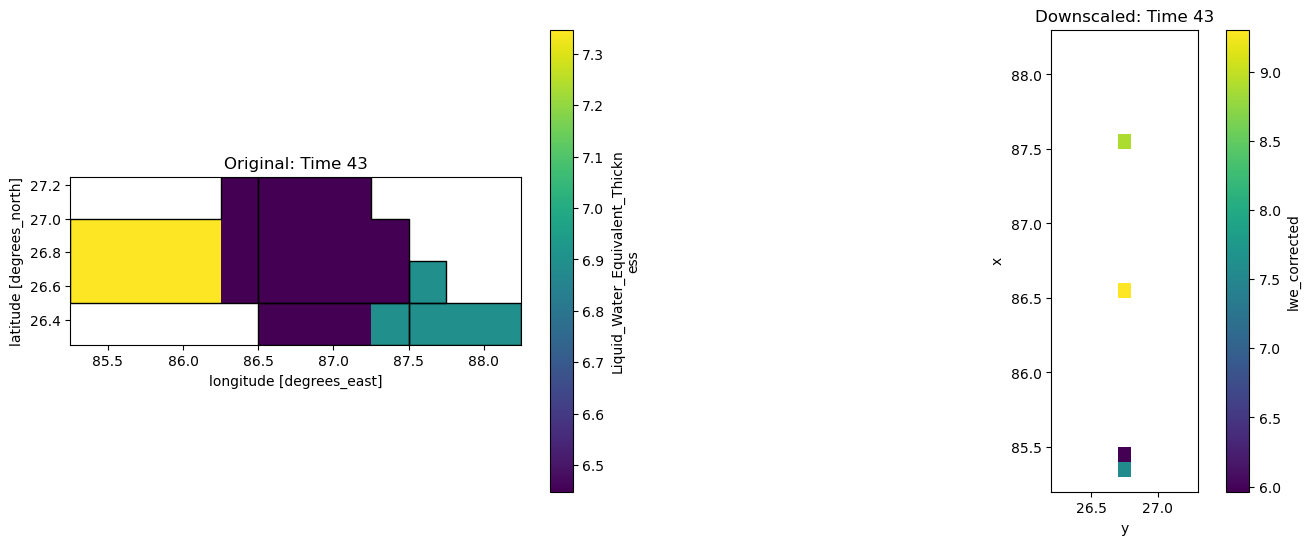

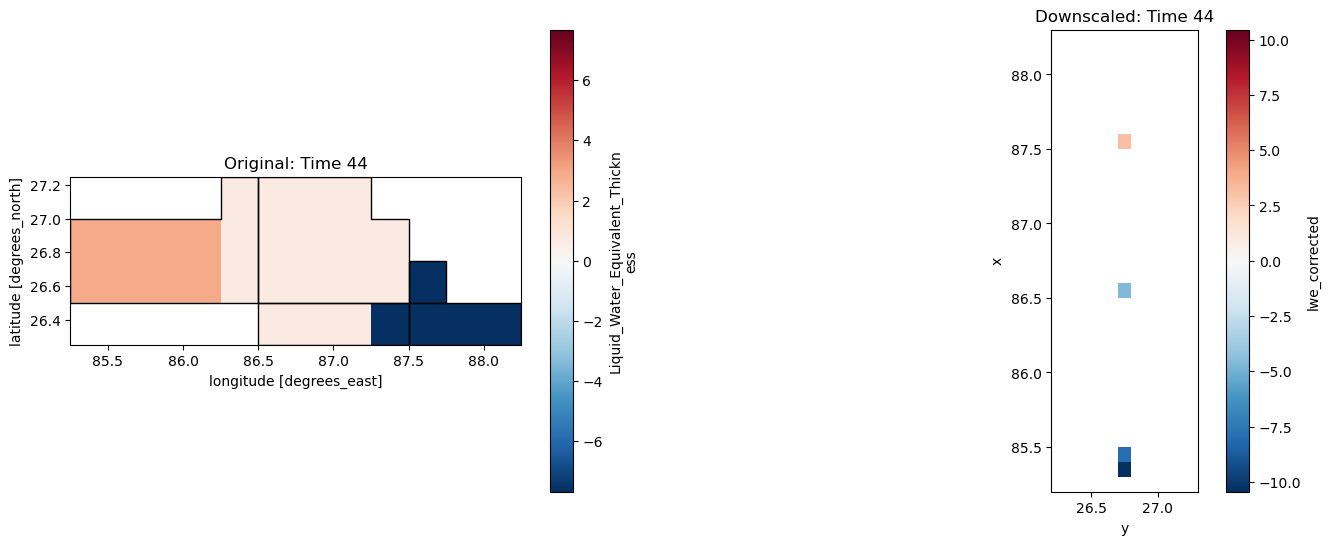

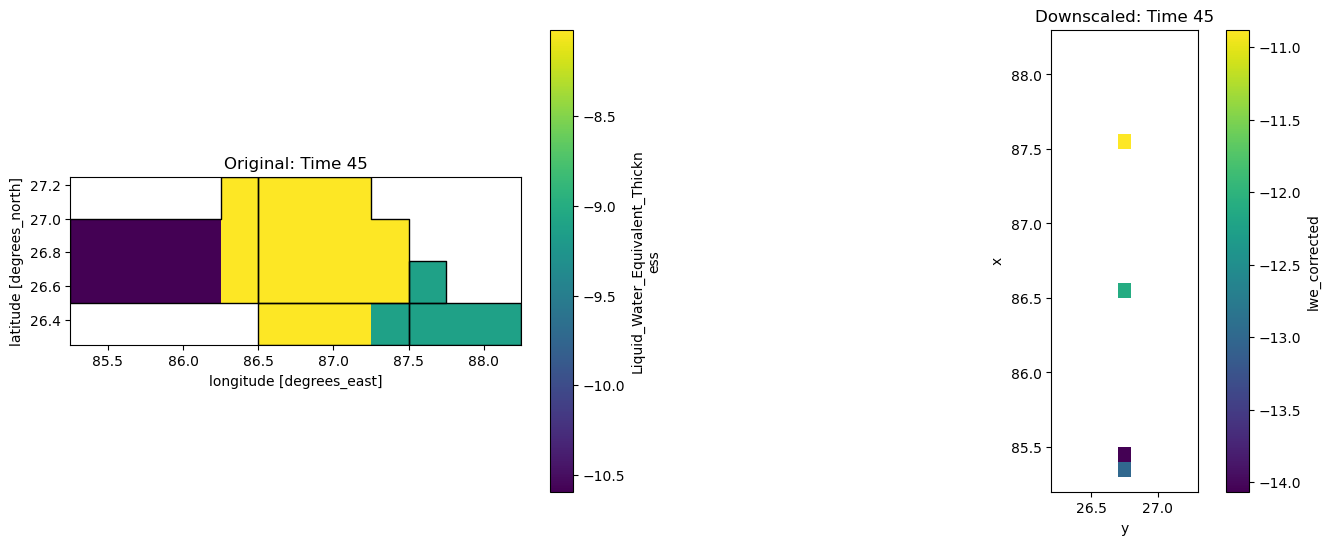

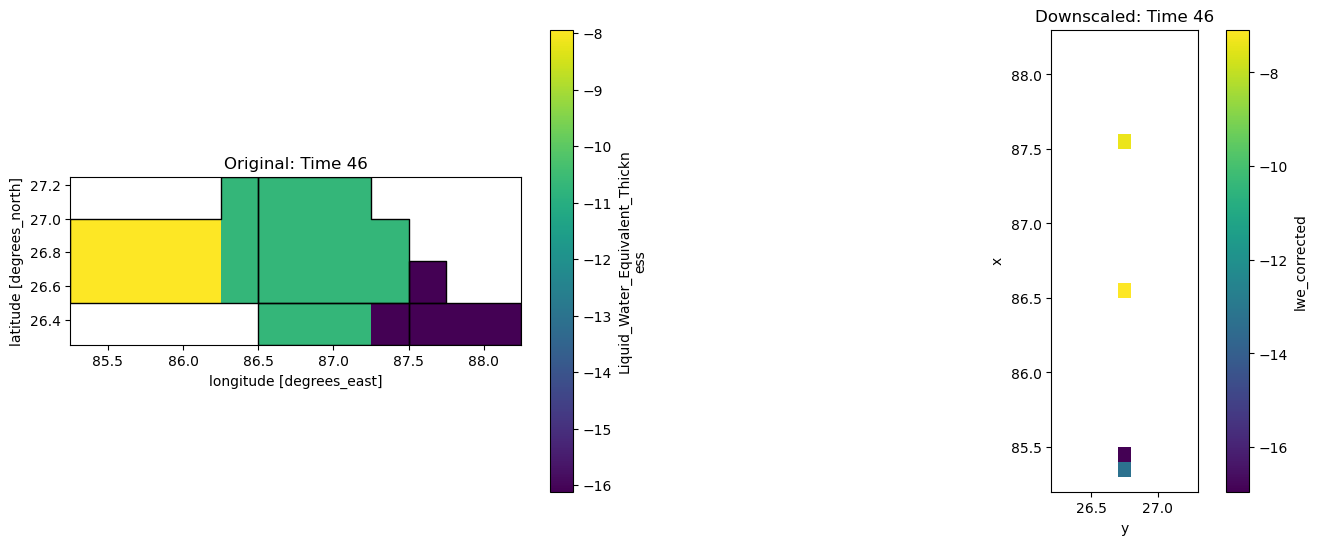

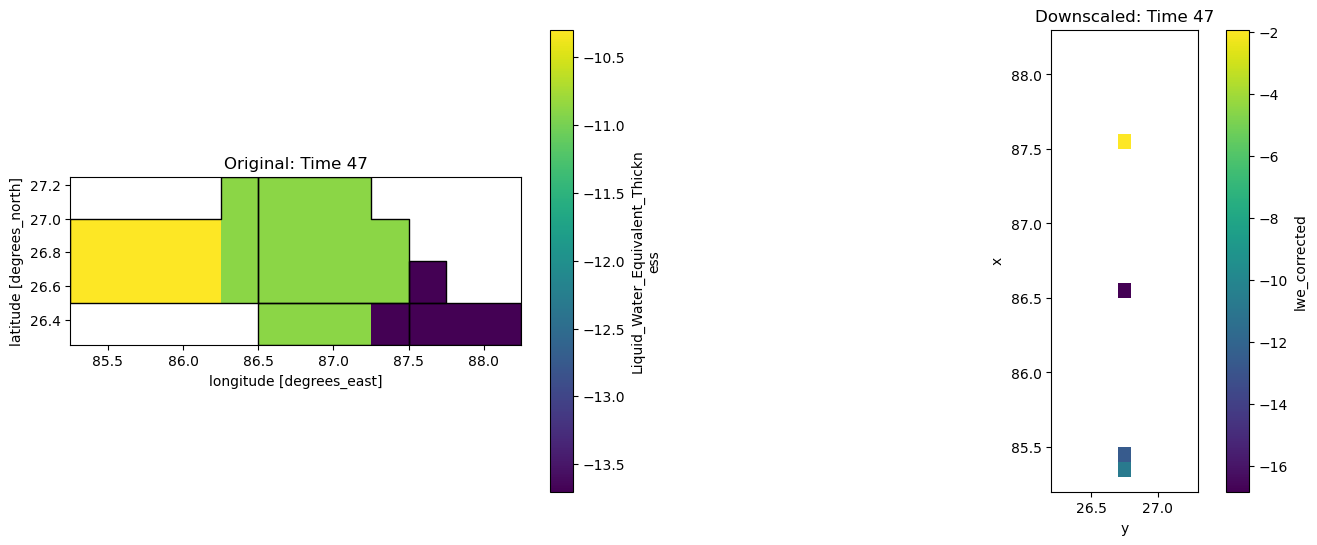

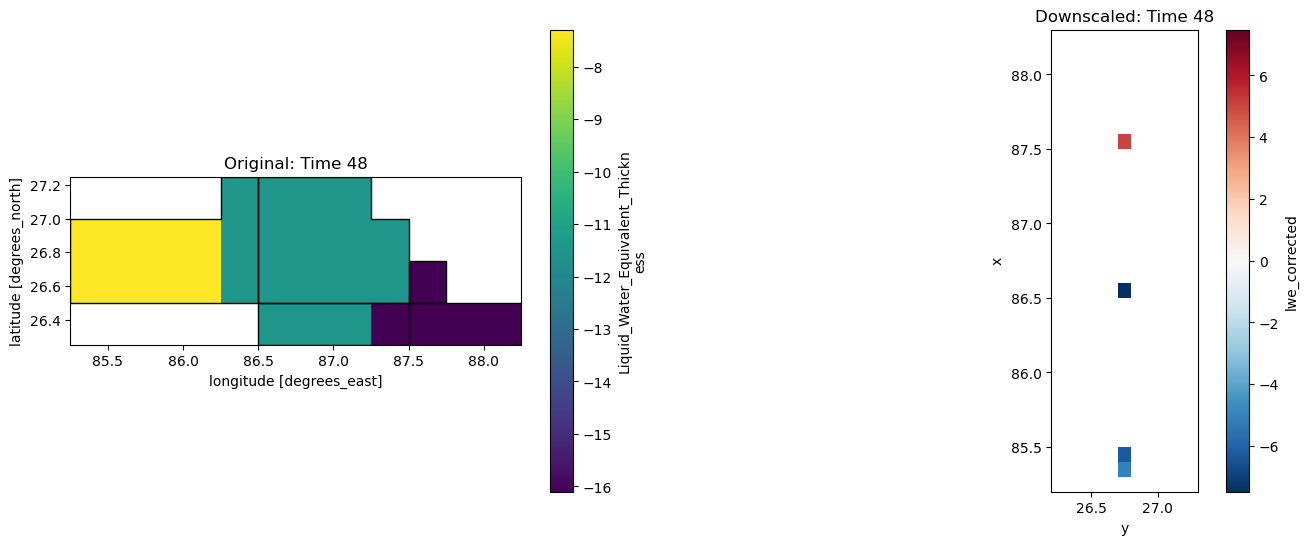

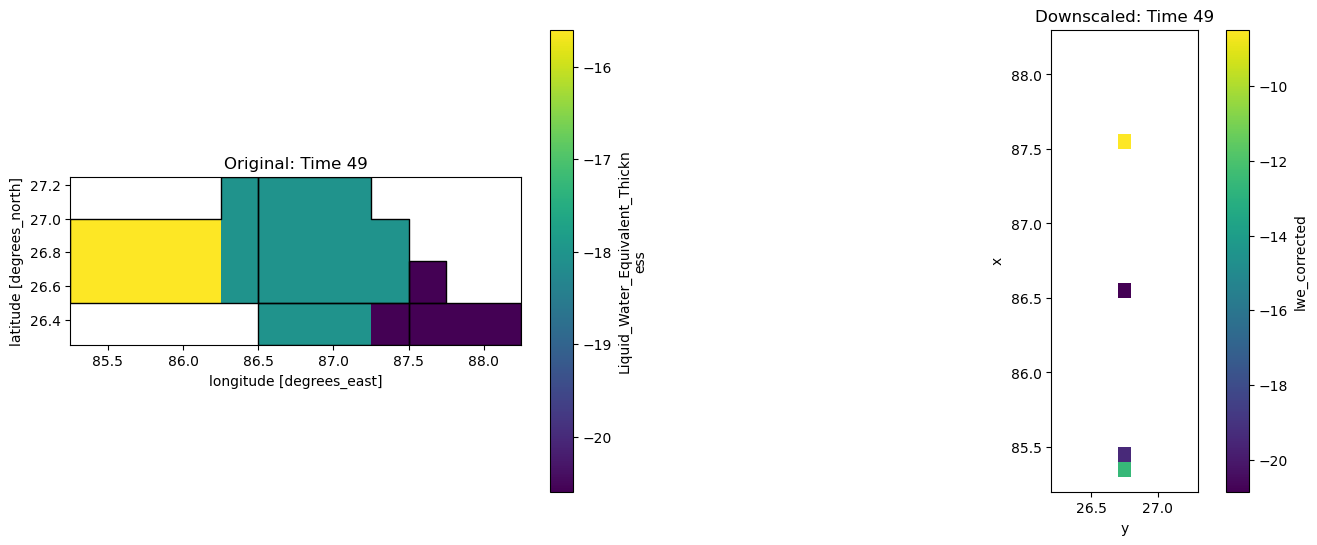

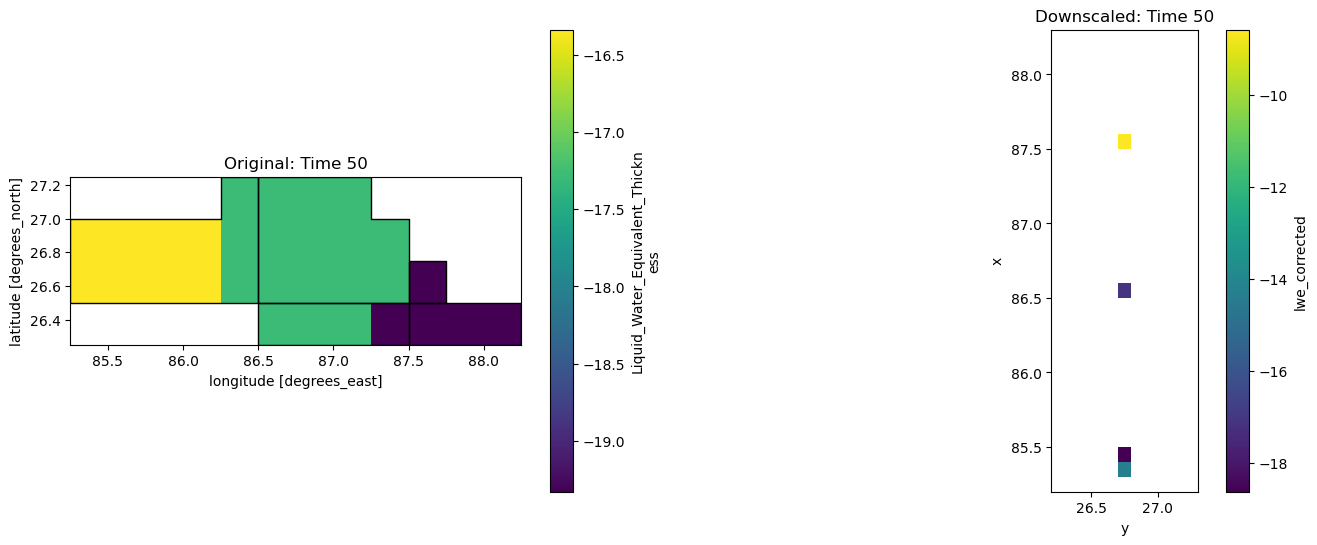

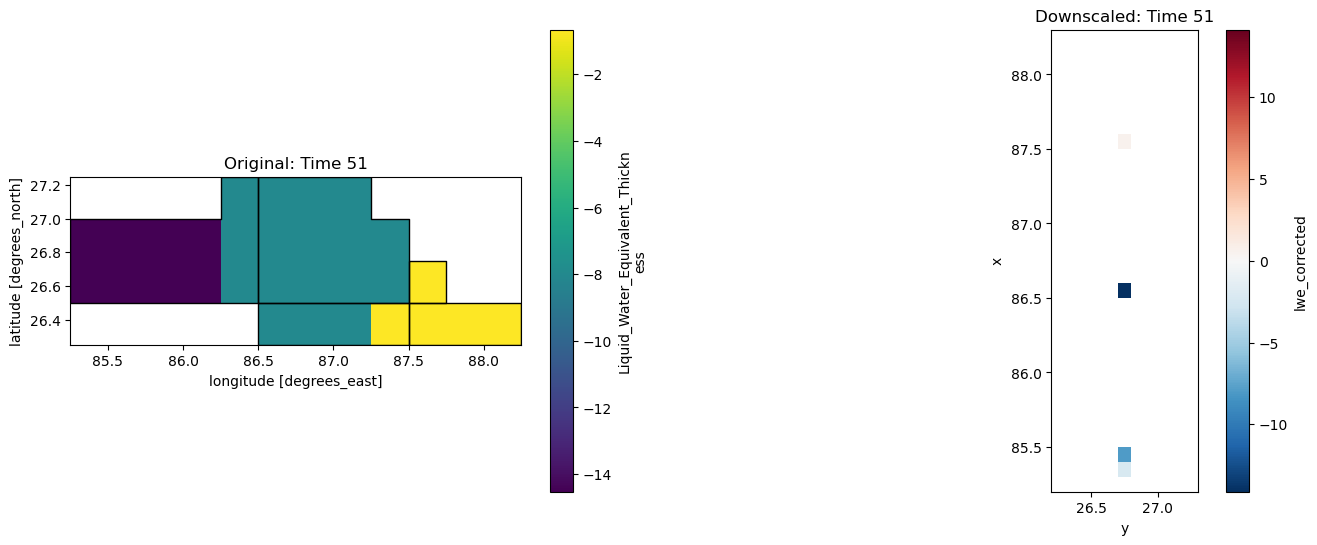

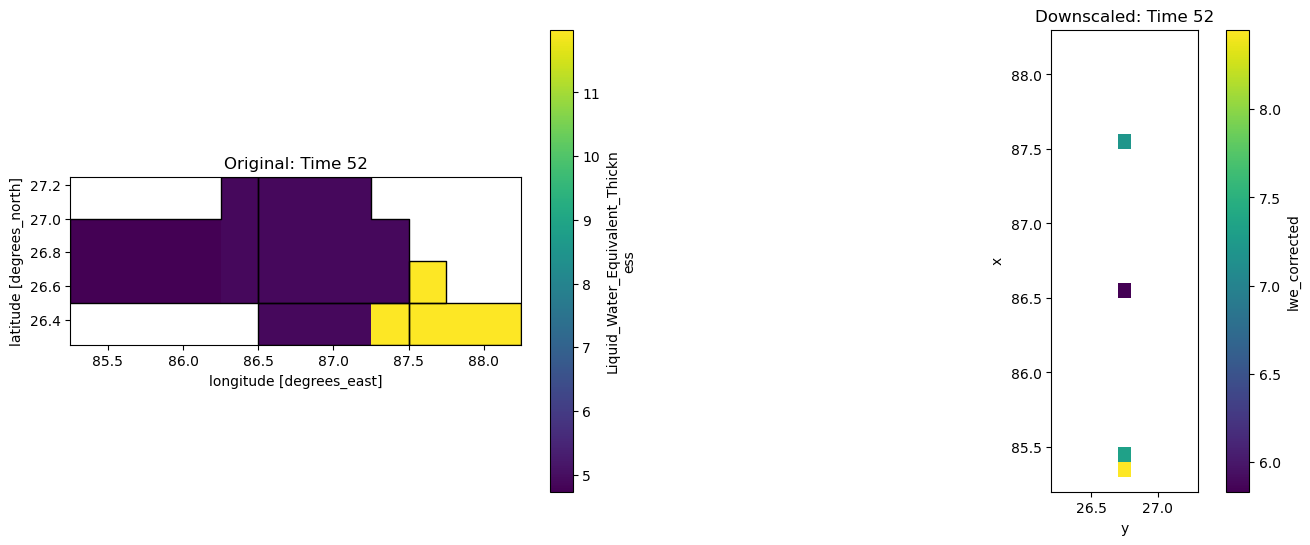

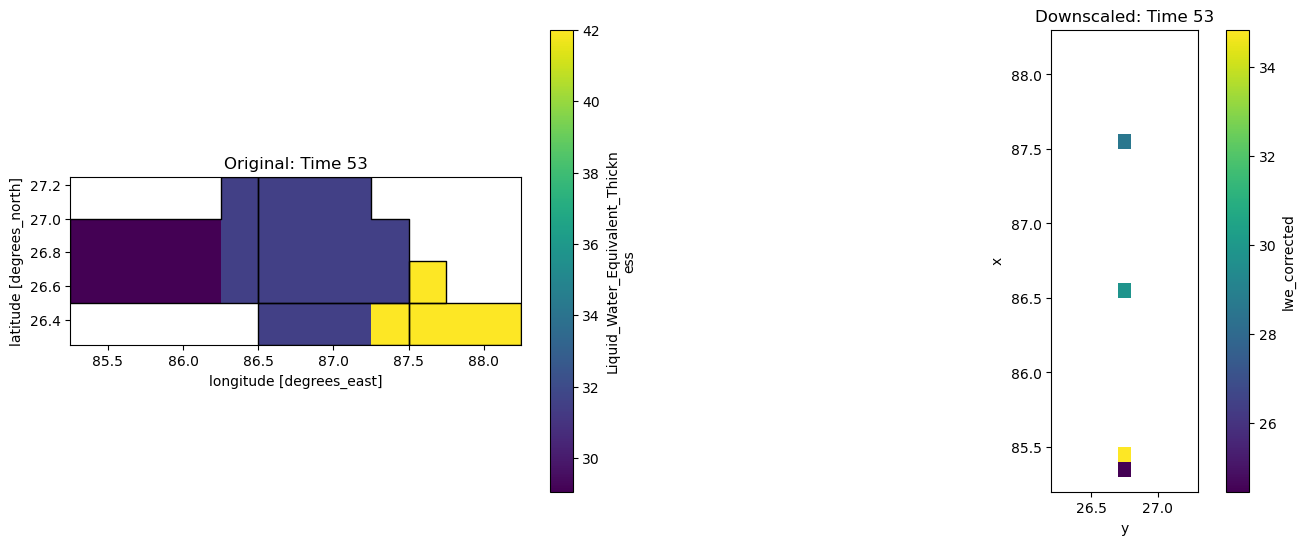

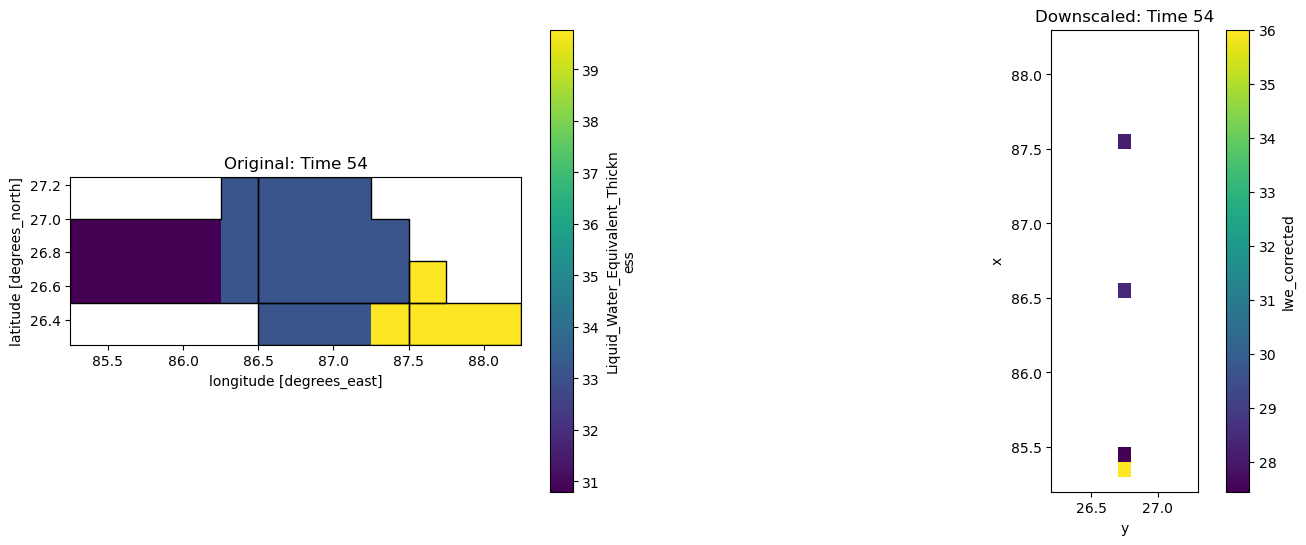

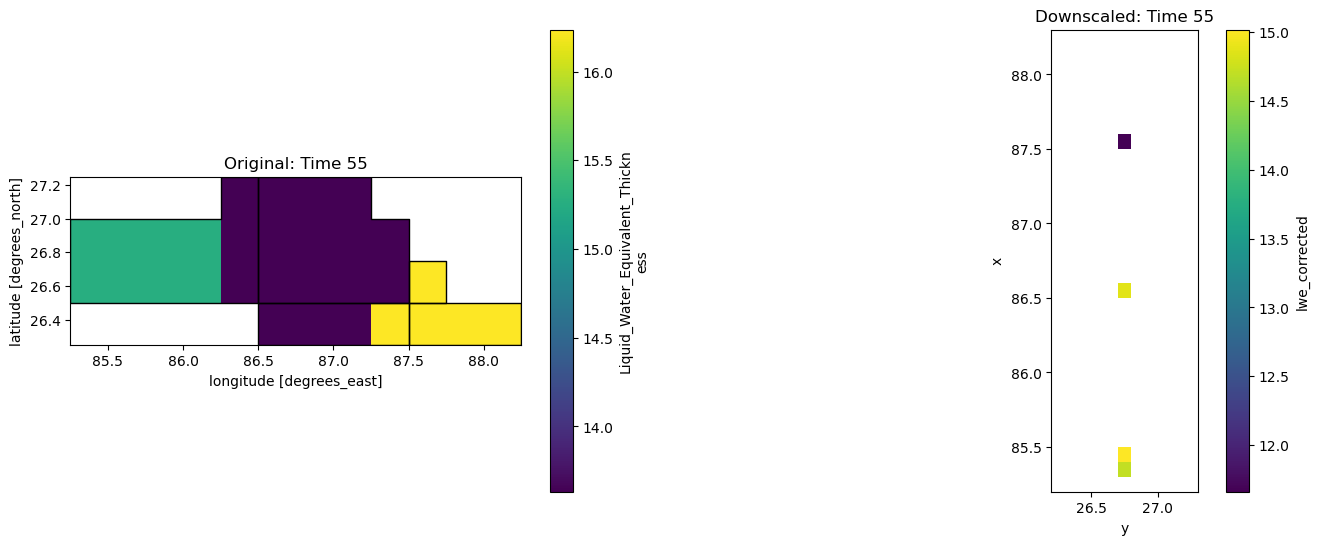

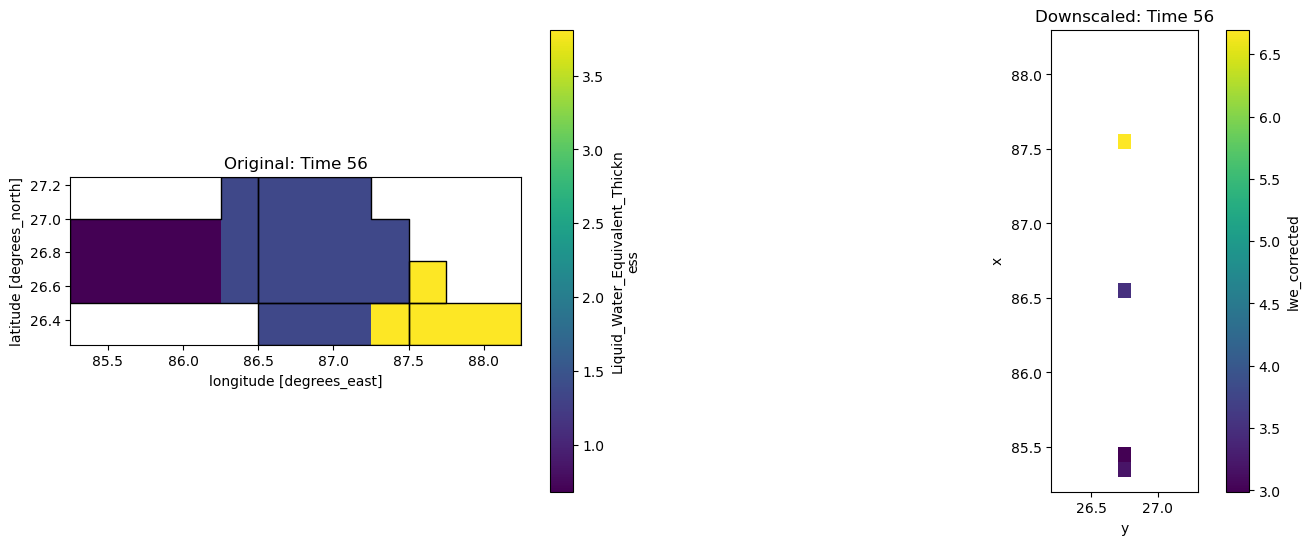

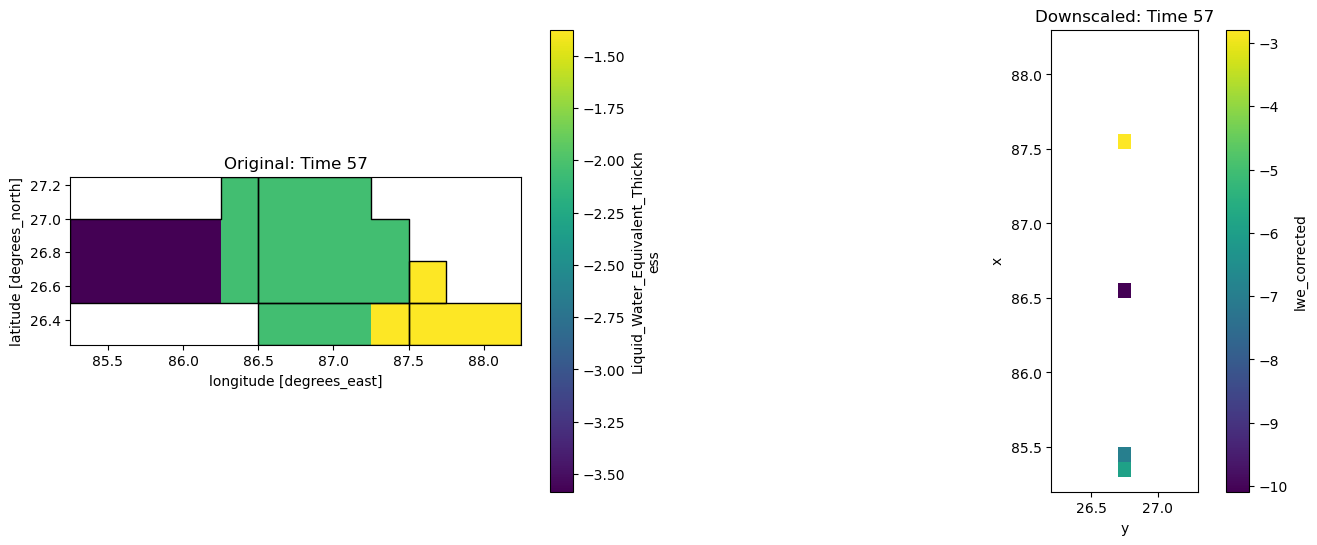

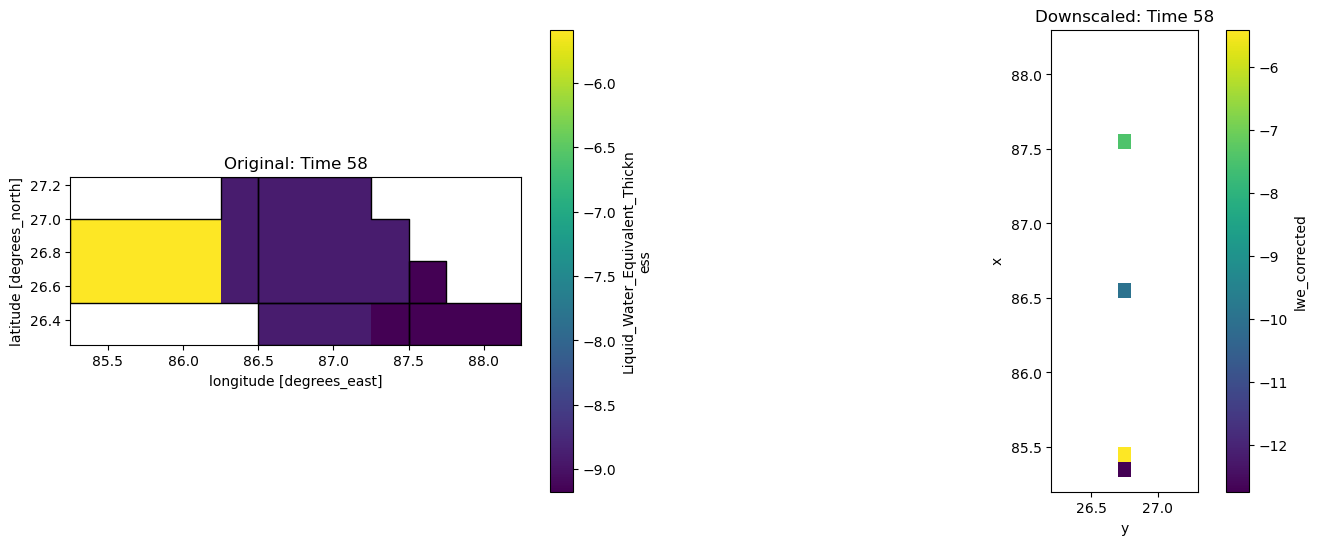

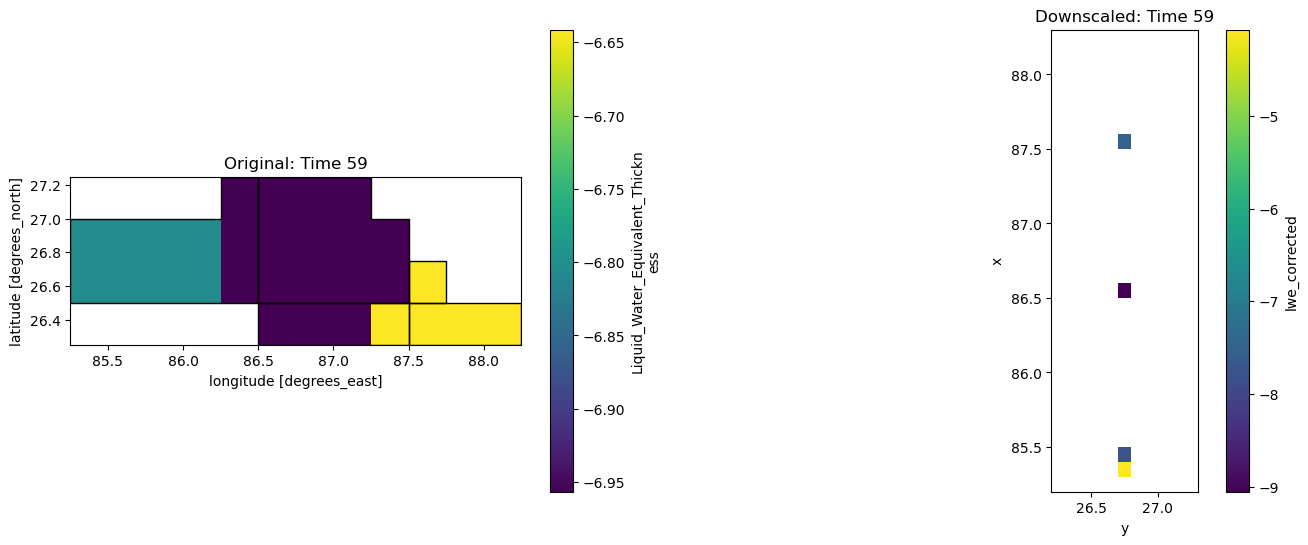

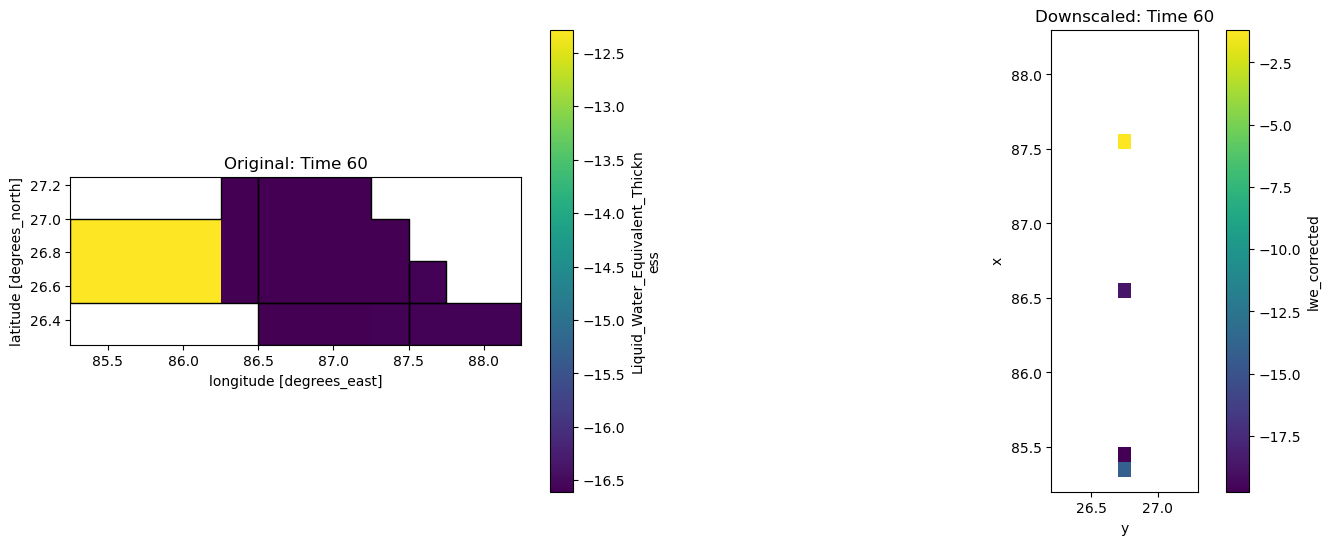

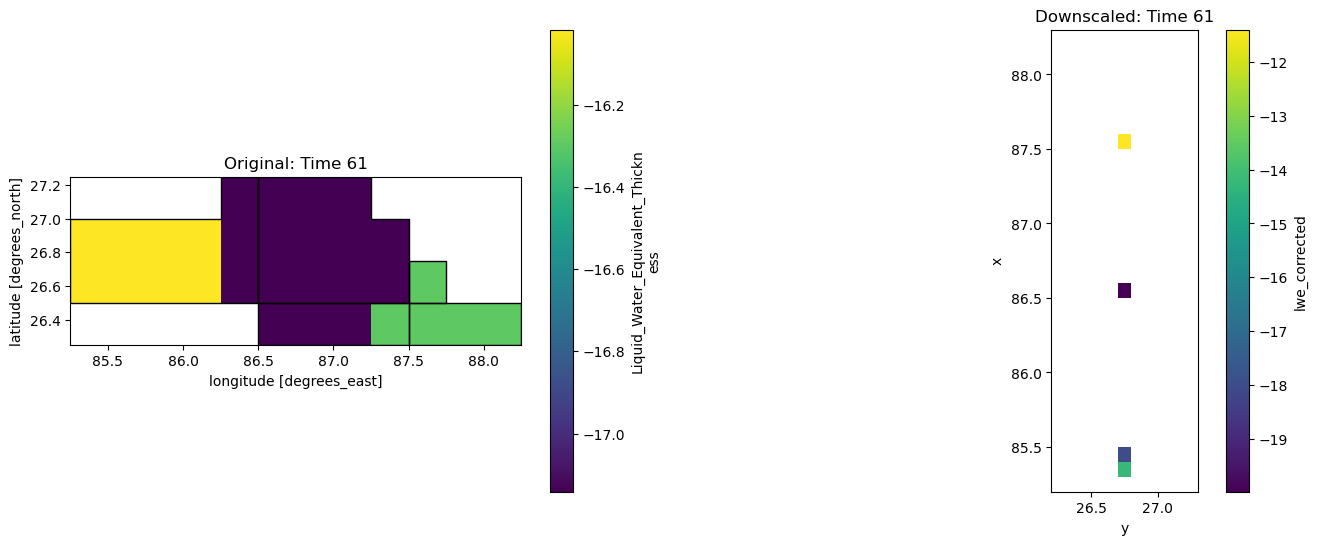

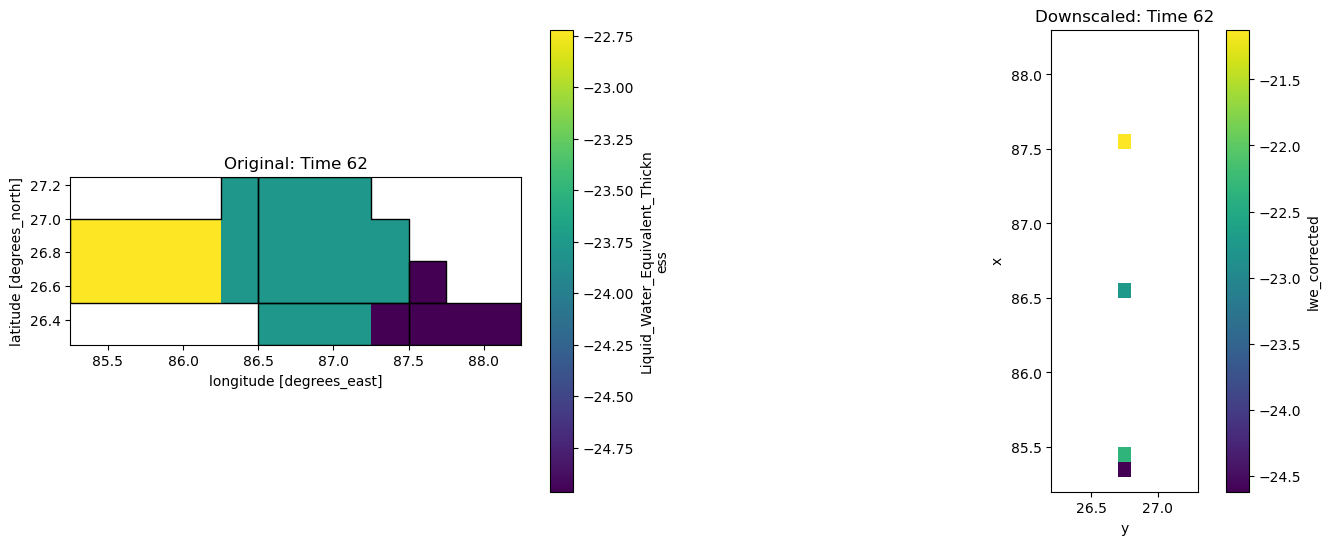

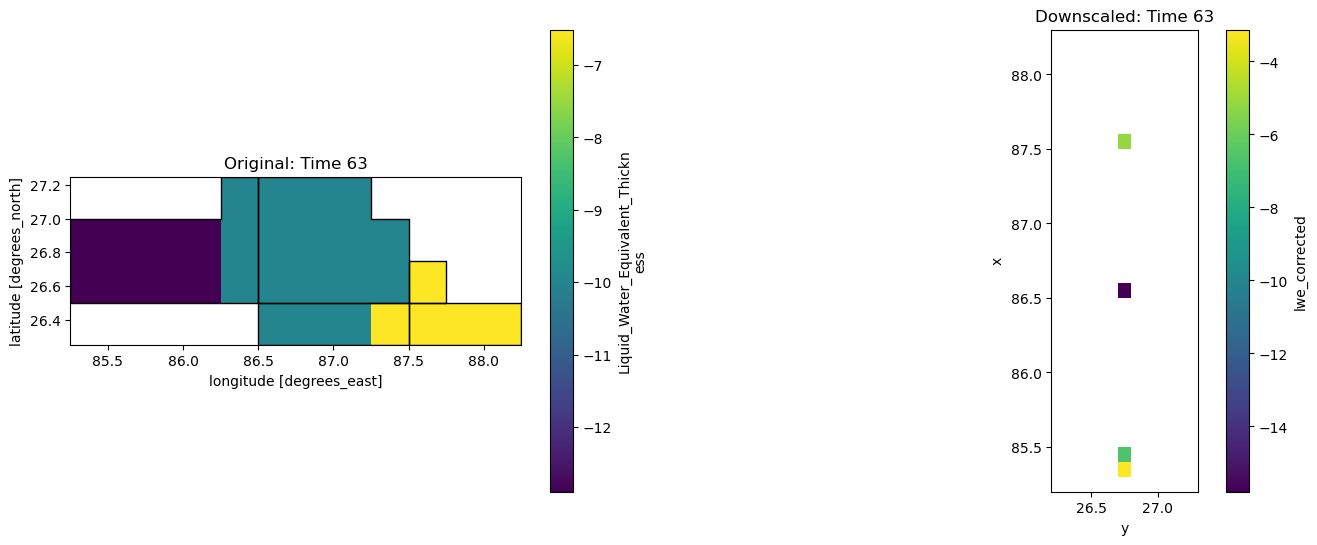

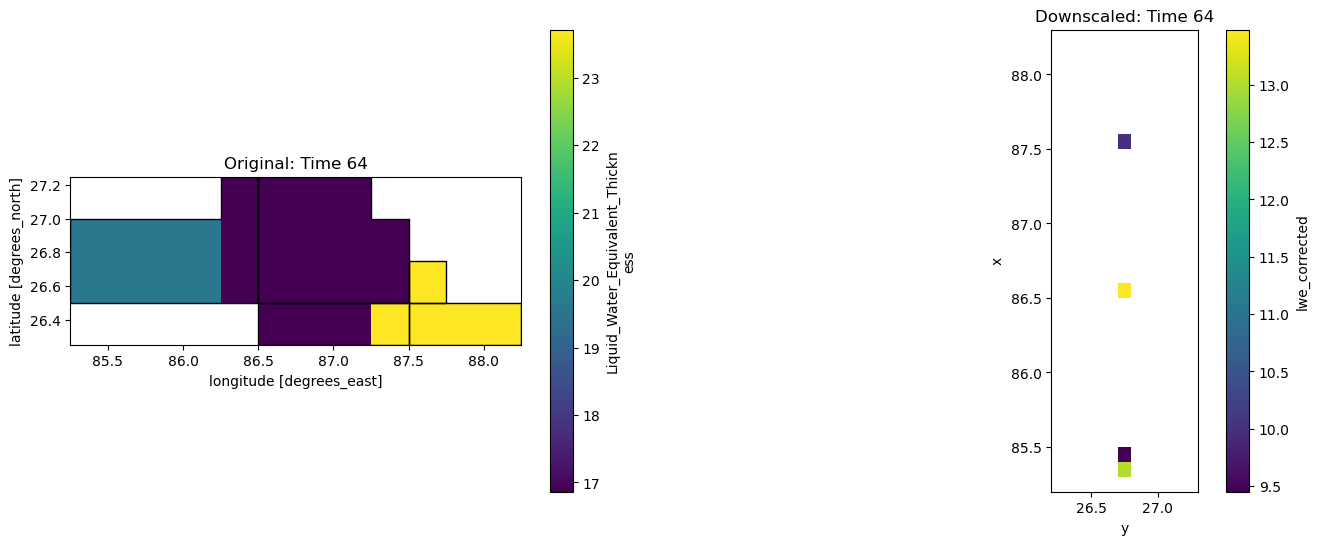

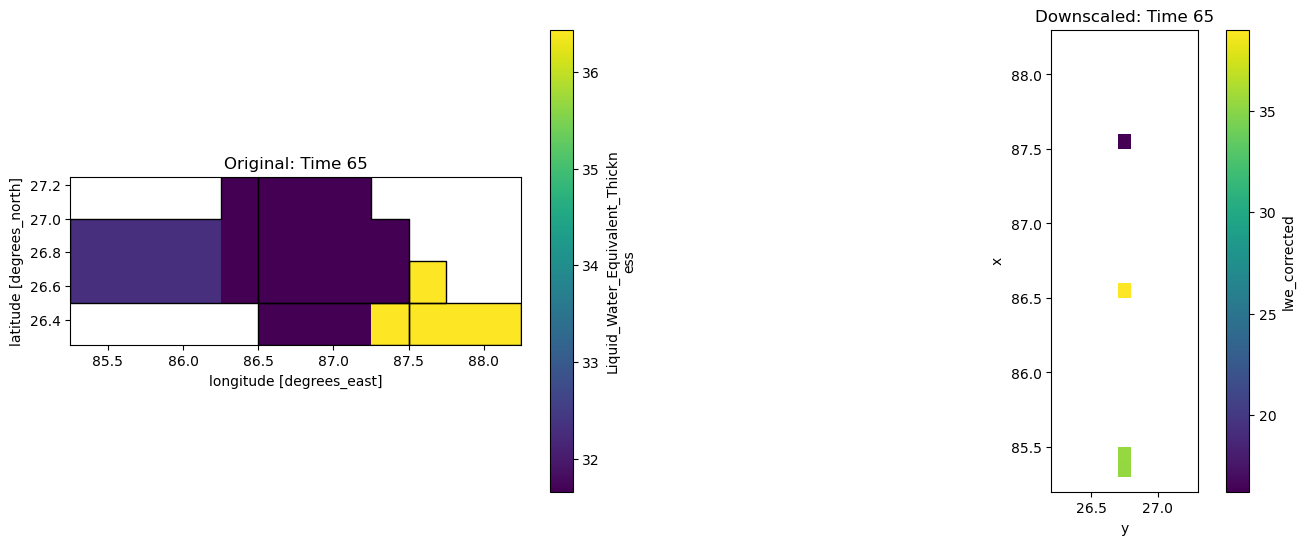

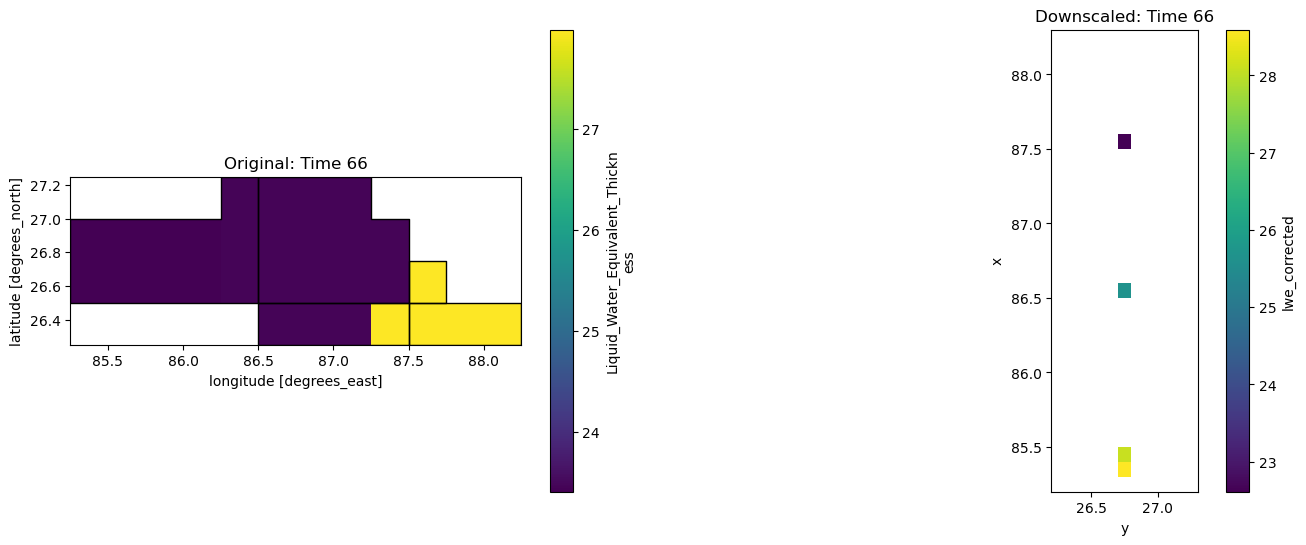

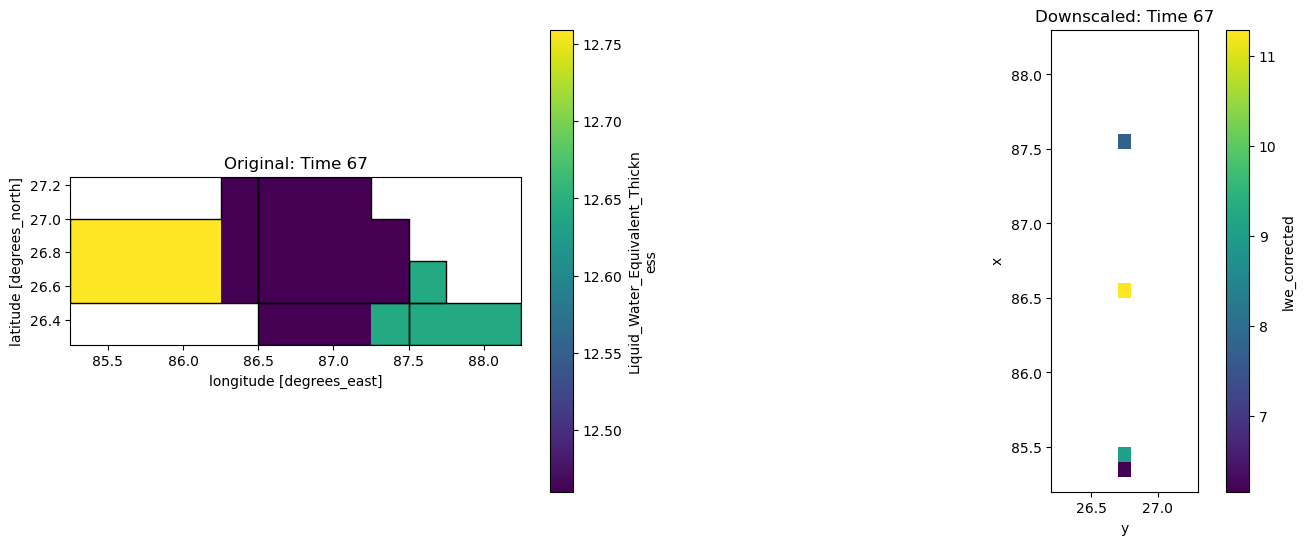

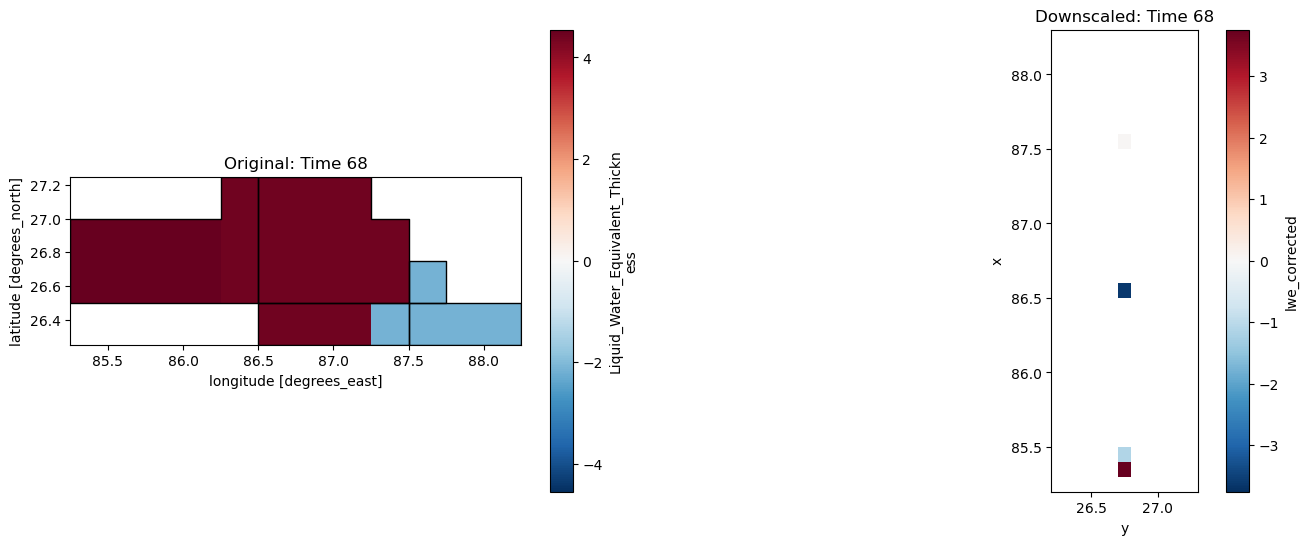

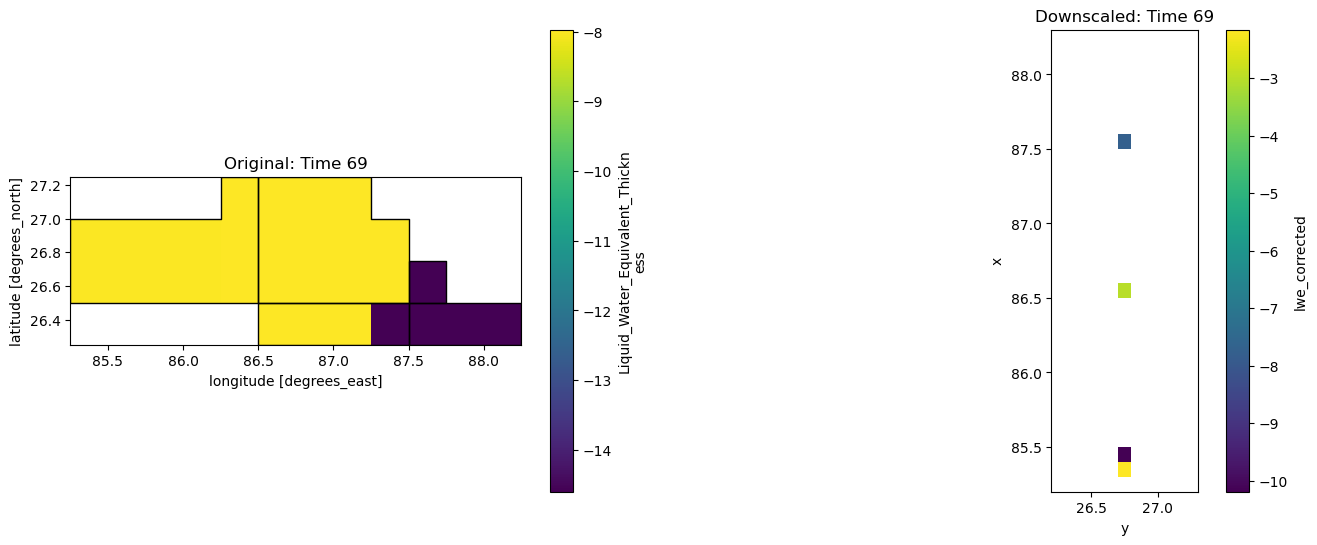

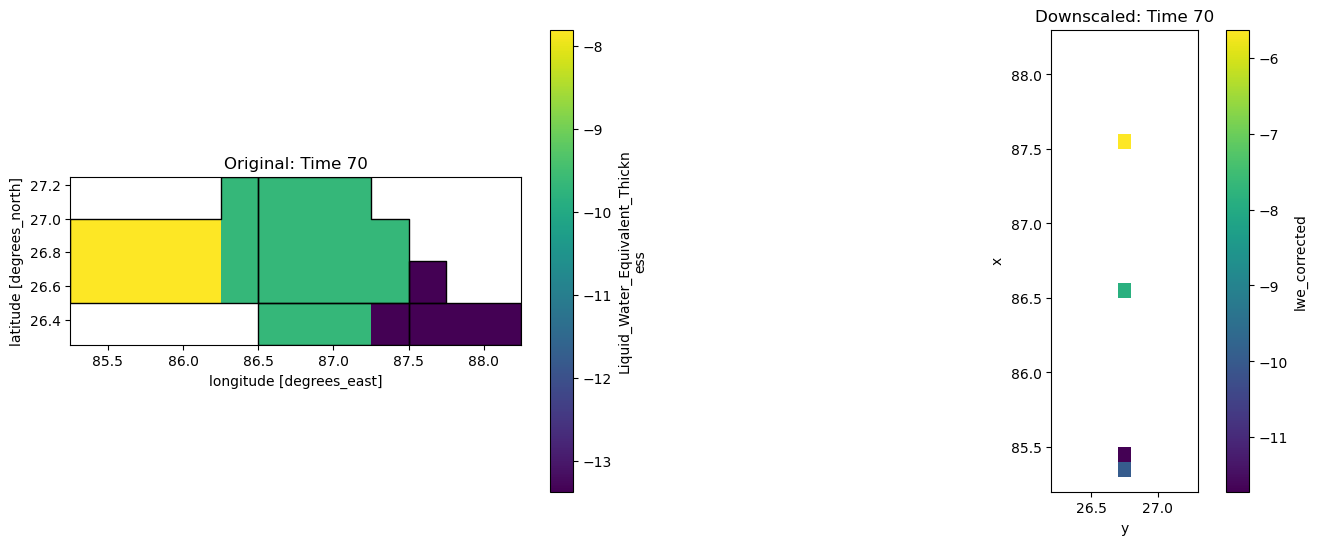

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Function to plot original vs downscaled for a single time period
def plot_comparison(time_idx, original, downscaled, shape, title=None):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot original dataset
    original.isel(time=time_idx).plot(ax=axs[0])
    shape.plot(ax=axs[0], edgecolor='black', facecolor='None')
    axs[0].set_title(f'Original: Time {time_idx}')

    # Plot downscaled dataset
    downscaled.isel(time=time_idx).plot(ax=axs[1])
    shape.plot(ax=axs[1], edgecolor='black', facecolor='None')
    axs[1].set_title(f'Downscaled: Time {time_idx}')

    if title:
        plt.suptitle(title)
    plt.show()

# Loop through each time period to plot and compare datasets
for t in range(184):
    plot_comparison(t, GR.lwe_thickness, new_lwe.lwe_corrected, nepal_shp)

# Function to plot a comparison for all months in a single year
def plot_year_comparison(year, original, downscaled, shape, time_index_map):
    # Assuming time_index_map is a dictionary that maps time index to a year-month pair
    times_in_year = [idx for idx, (yr, _) in time_index_map.items() if yr == year]

    n = len(times_in_year)
    fig, axs = plt.subplots(n, 2, figsize=(16, 6 * n))

    for i, t_idx in enumerate(times_in_year):
        # Plot original dataset
        original.isel(time=t_idx).plot(ax=axs[i, 0])
        shape.plot(ax=axs[i, 0], edgecolor='black', facecolor='None')
        axs[i, 0].set_title(f'Original: Time {t_idx}')

        # Plot downscaled dataset
        downscaled.isel(time=t_idx).plot(ax=axs[i, 1])
        shape.plot(ax=axs[i, 1], edgecolor='black', facecolor='None')
        axs[i, 1].set_title(f'Downscaled: Time {t_idx}')

    plt.suptitle(f'Comparison for Year {year}')
    plt.tight_layout()
    plt.show()

# Example usage for a specific year, assuming time_index_map is available
plot_year_comparison(2015, GR.lwe_thickness, new_lwe.lwe_corrected, nepal_shp, time_index_map)